## Machine Learning Project - 2023

## Group : 19

**<div style="direction:rtl">בסוף המחברת נמצא הPIPELINE. לטובת הבנת התהליך וכל הגרפים בדרך (לא רק המודל הסופי) יש לבצע RUN ALL.</div>**


In [1]:
#imports
import warnings
warnings.filterwarnings('ignore')
import random
import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.metrics import auc, roc_auc_score, mean_squared_error,roc_curve,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import category_encoders as ce
%matplotlib inline


In [2]:
def Import_train_for_preproccessing(file_name):
    #importing training set
    train_visual_set=pd.read_csv(file_name)
    #creating a copy the dataset
    cleaned_train_set=train_visual_set.copy()

    #Removing examples with at least 3 NAN
    column_names=list(np.array(train_visual_set.columns[:-1]))

    for feature in column_names:
        # droping rows with at least 3 NAN
        cleaned_train_set.dropna(thresh= (cleaned_train_set.shape[1]-1) - 2, inplace=True)
    return cleaned_train_set


**<div style="direction:rtl">חלק ראשון אקספלוריזציה</div>**


<div style="direction:rtl">נציג את הנתונים באופן ויזואלי על מנת לראות איך הפיצרים מתפלגים ואיזה קשרים יש בין הפיצ'רים.</div>


In [3]:
def Plot_features(train_to_plot):
    
    train_to_plt_cat=train_to_plot.copy()

    #Removing categorial features from column name list
    column_names=list(np.array(train_to_plot.columns[:-1]))
    numeric_column_names=column_names.copy()
    list_to_remove=["sha256","file_type_trid","C","label","has_debug","has_relocations","has_resources","has_signature","has_tls"]
    for feature in column_names:
        if feature in list_to_remove:
            numeric_column_names.remove(feature)


    #PLOTTING HISTOGRAM NUMERIC FEATURES
    #Plotting historigrams for each numeric feature
    for num_feature in numeric_column_names:
        plt.hist(train_to_plot[num_feature],bins=20)
        plt.title(num_feature)
        plt.yscale("log")
        plt.show()
        print("Number of NAN in {0}:".format(num_feature), train_to_plot[num_feature].isnull().sum())
        sns.scatterplot(train_to_plot[num_feature])
        plt.title(num_feature)
        plt.yscale("log")
        plt.show()


    #PLOTTING HISTOGRAM CATEGORIAL FEATURES
    #Plotting historigrams for each categorial feature
    for cat_feature in list_to_remove:
        train_to_plt_cat[cat_feature].value_counts().head(20).plot.barh()
        plt.title(cat_feature)
        print("Number of NAN in {0}:".format(cat_feature), train_to_plt_cat[cat_feature].isnull().sum())
        plt.show()


    #CORELATION PLOTTING NUMERIC FEATURES
    #plotting correlation heatmaps between numerical features
    plt.figure(figsize=(14, 6))
    sns.heatmap(train_to_plot[numeric_column_names].corr(),annot=True)
    plt.show()


    #CORELATION PLOTTING CATEGORIC FEATURES
    #plotting categorial heatmaps
    plt.figure(figsize=(14, 6))
    # transforming categoric columns to numeric values
    df_numeric = train_to_plt_cat[list_to_remove].apply(lambda x: pd.factorize(x)[0])
    # Create the correlation matrix
    corr_matrix = df_numeric.corr()
    sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True)
    plt.show()

<div style="direction:rtl">כעת נציג את התפלגות הפיצ'רים דרך היסטוגרמה וגרף פיזור על מנת לנסות לאפיין איך כל פיצ'ר מתפלג. הסבר אודות מדיניות ההחלטות שקיבלנו מפורט בחלק 2 - העיבוד המקדים.</div>


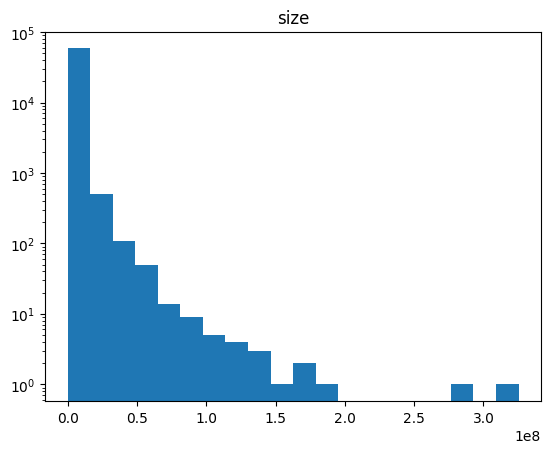

Number of NAN in size: 0


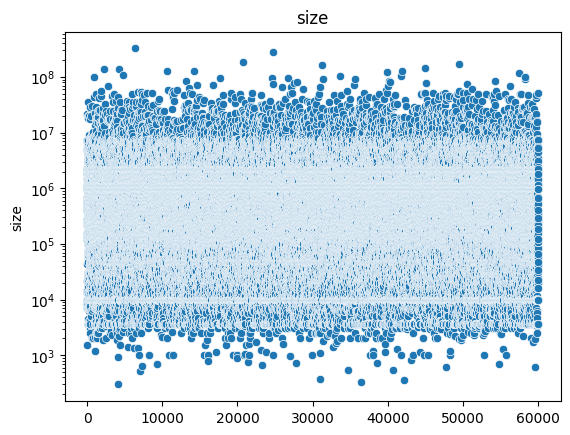

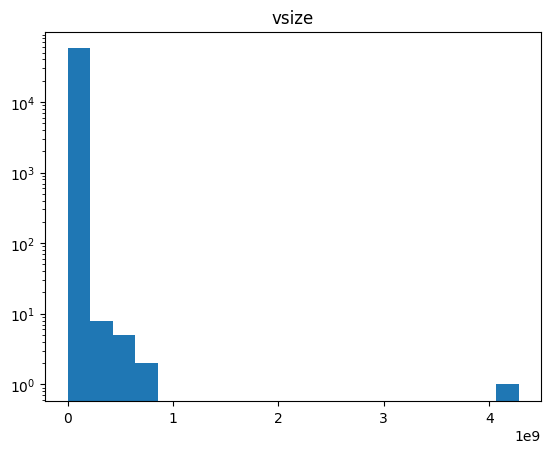

Number of NAN in vsize: 1855


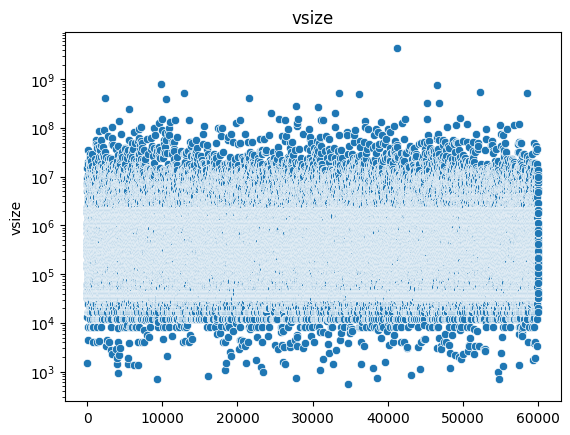

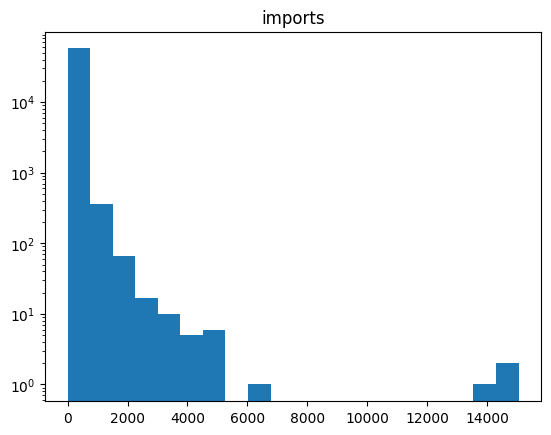

Number of NAN in imports: 1661


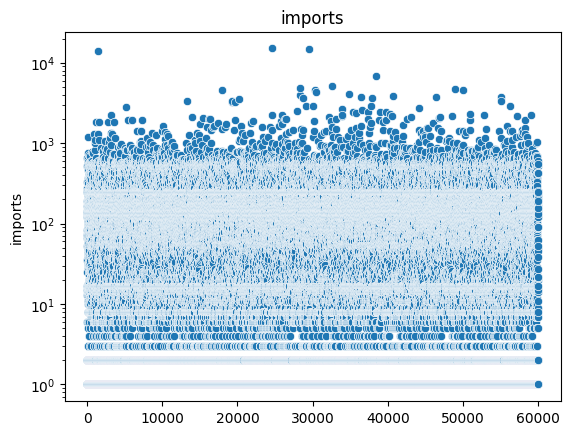

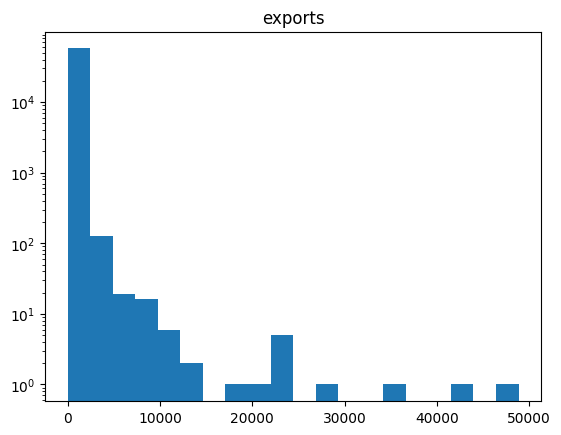

Number of NAN in exports: 1993


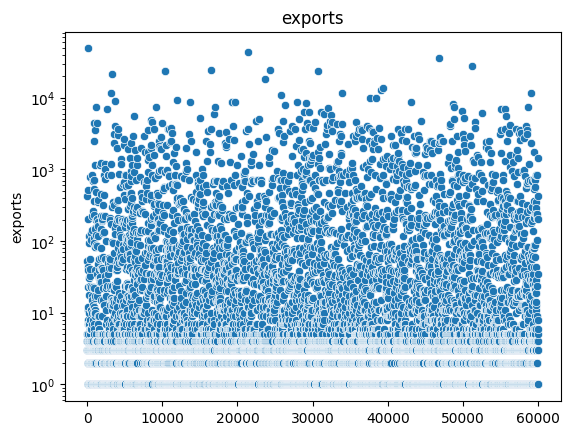

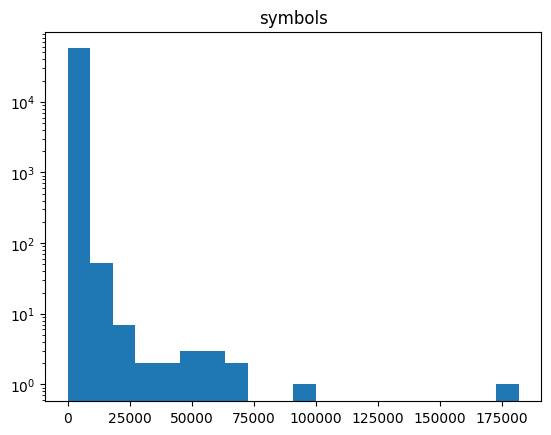

Number of NAN in symbols: 2534


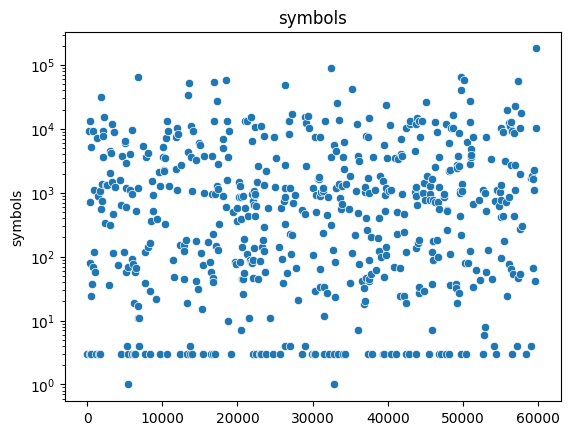

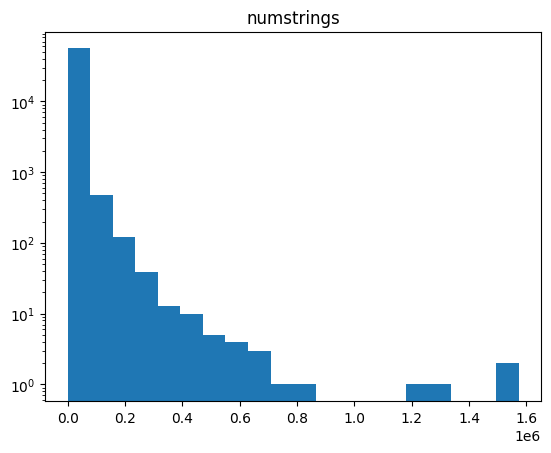

Number of NAN in numstrings: 2601


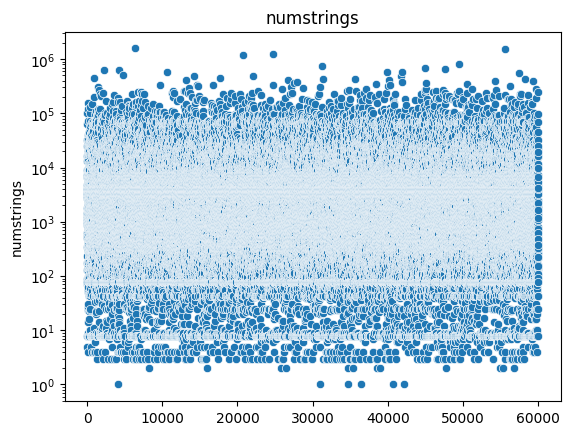

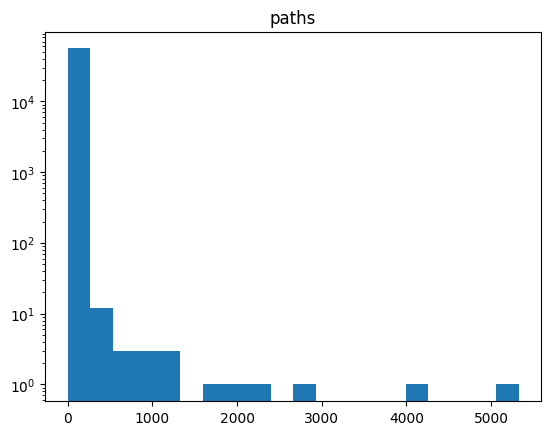

Number of NAN in paths: 3520


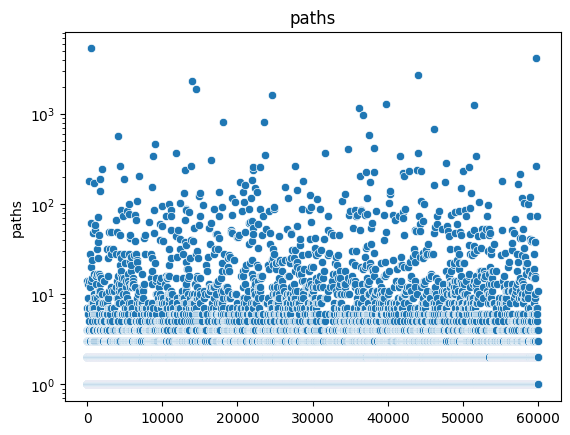

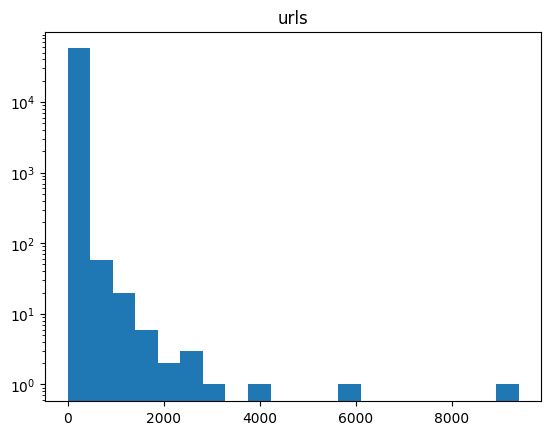

Number of NAN in urls: 2260


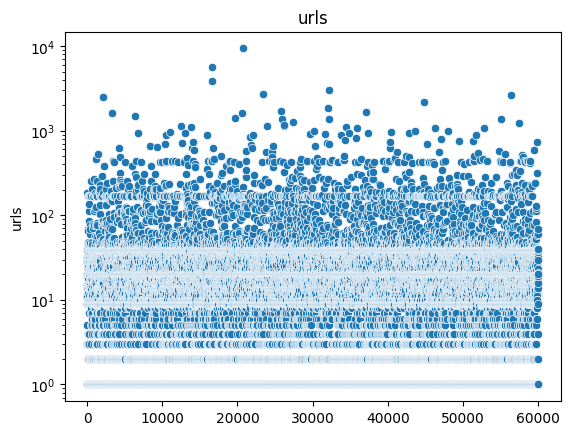

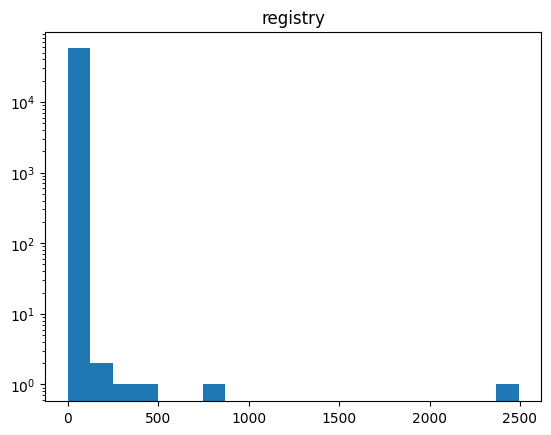

Number of NAN in registry: 2424


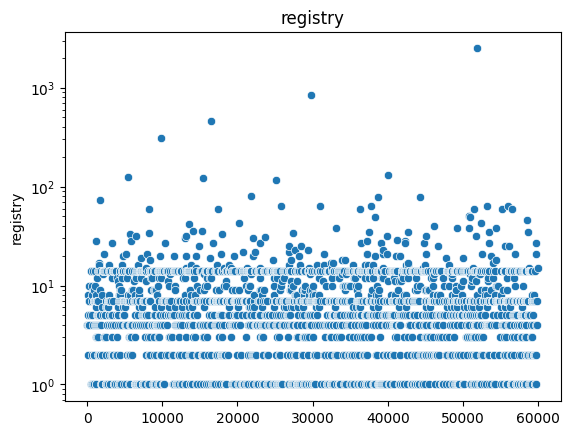

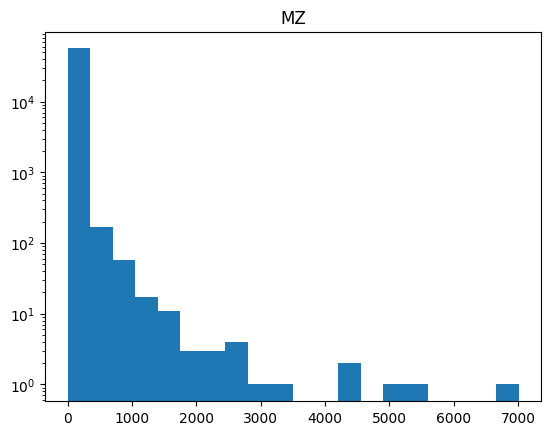

Number of NAN in MZ: 2951


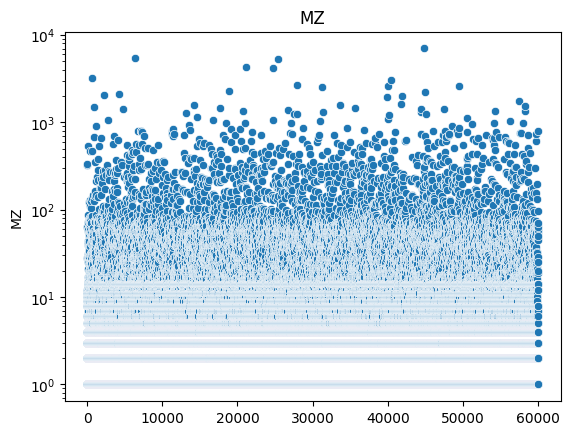

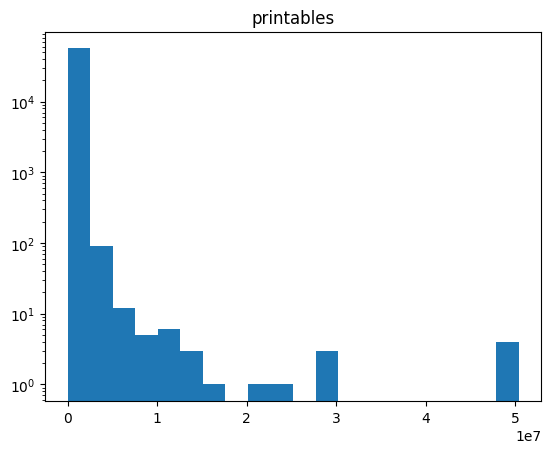

Number of NAN in printables: 2619


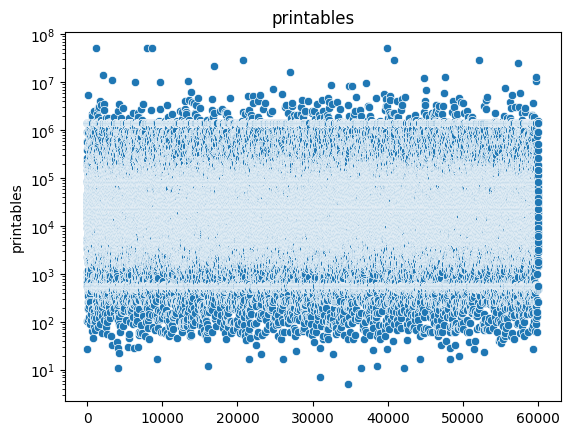

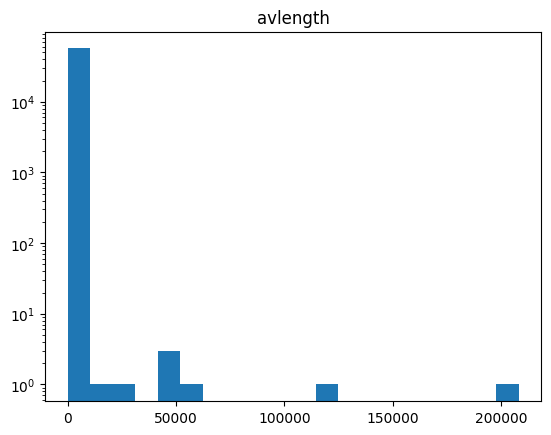

Number of NAN in avlength: 2641


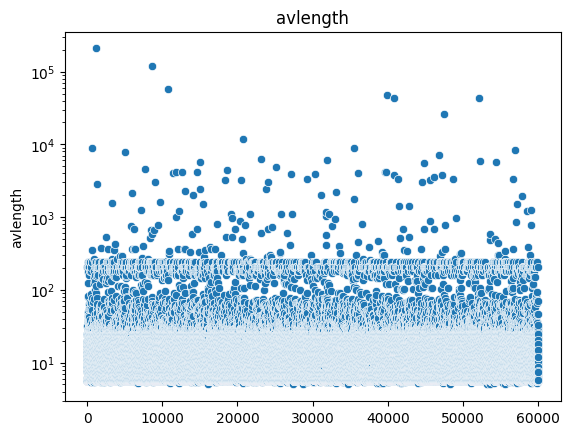

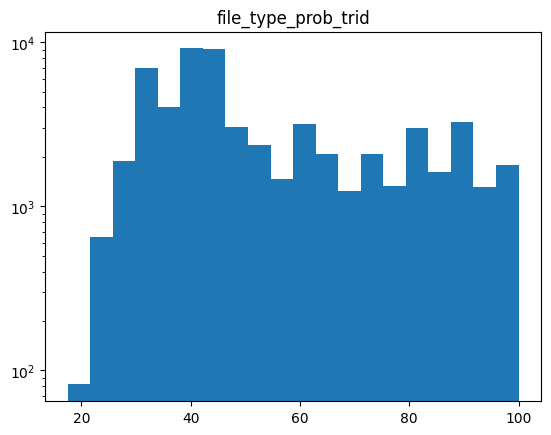

Number of NAN in file_type_prob_trid: 0


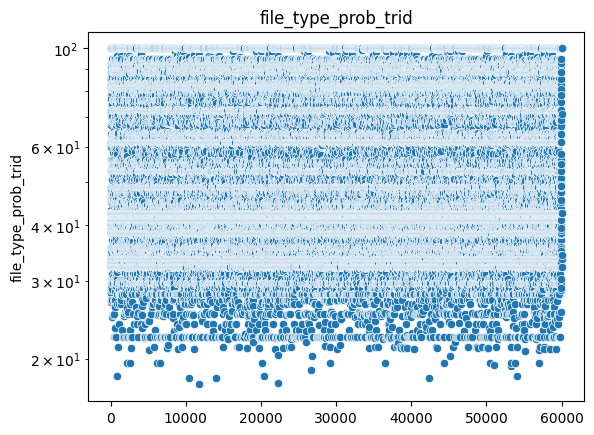

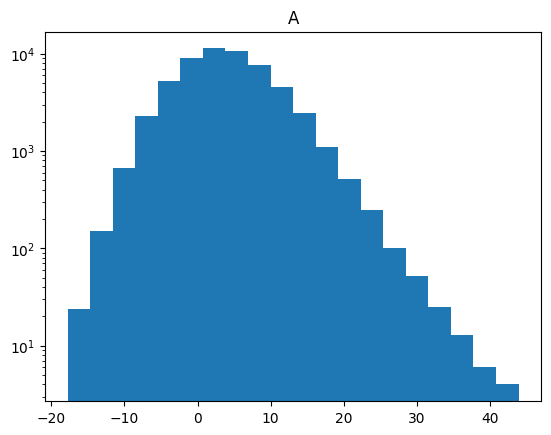

Number of NAN in A: 3559


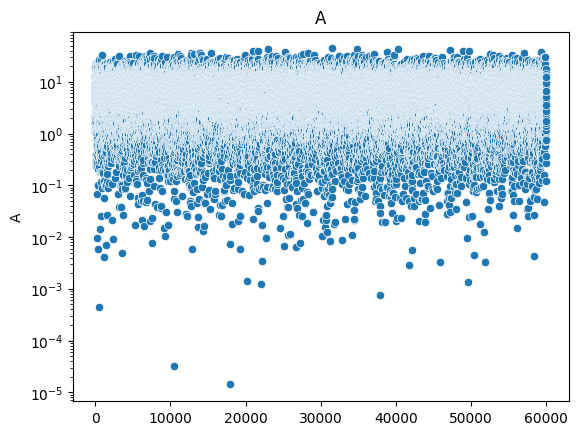

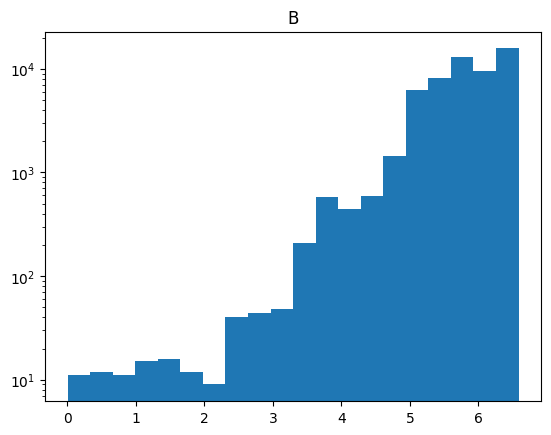

Number of NAN in B: 3622


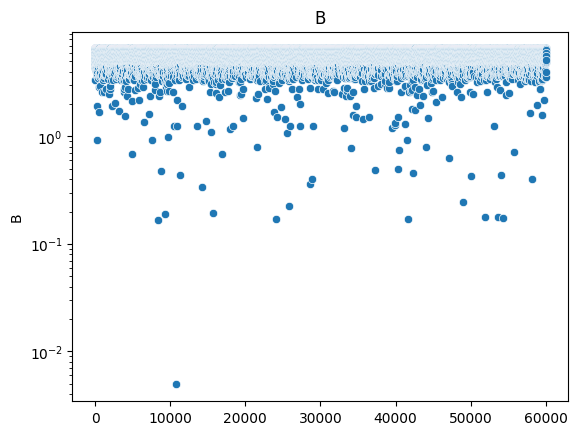

Number of NAN in sha256: 0


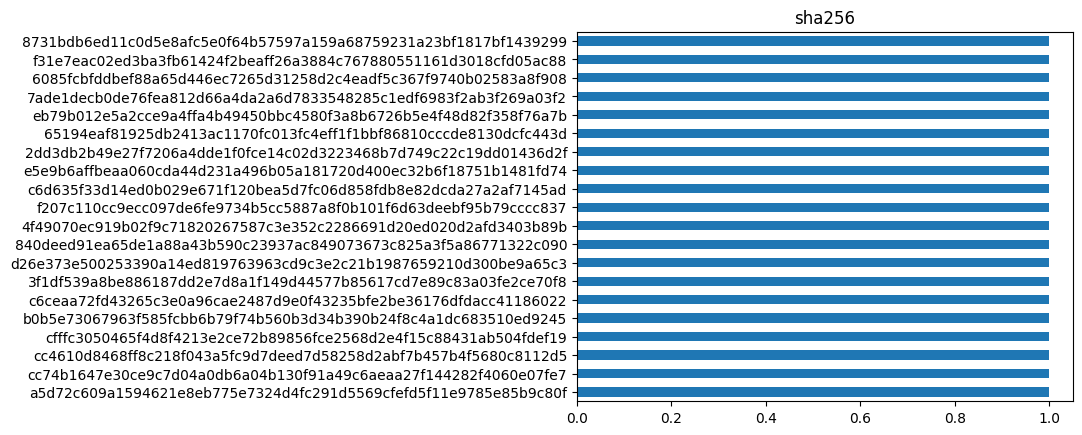

Number of NAN in file_type_trid: 0


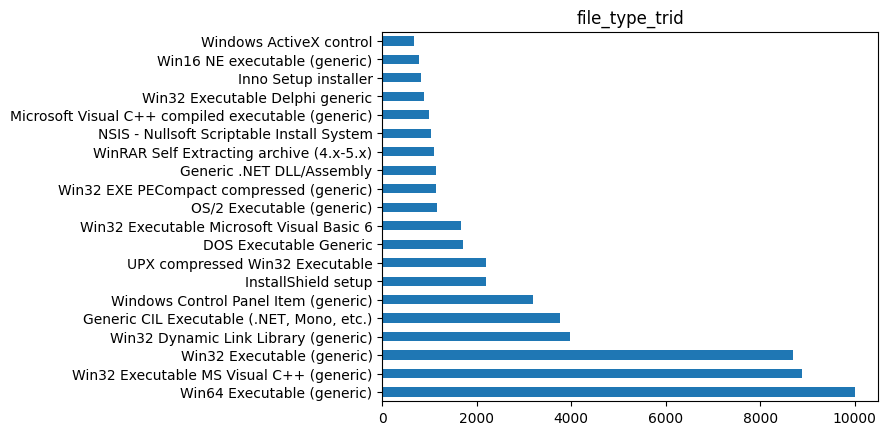

Number of NAN in C: 1956


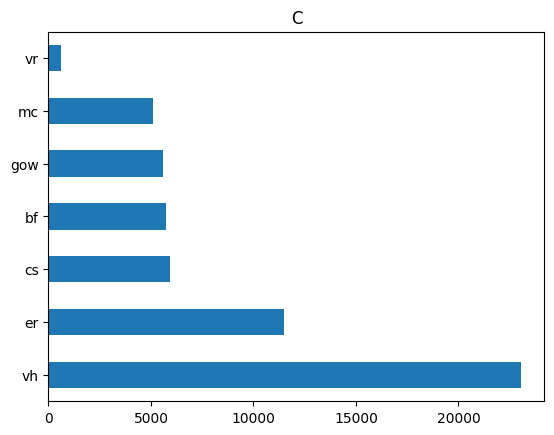

Number of NAN in label: 0


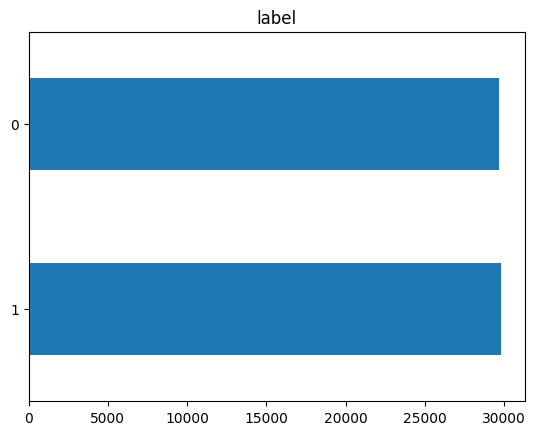

Number of NAN in has_debug: 2808


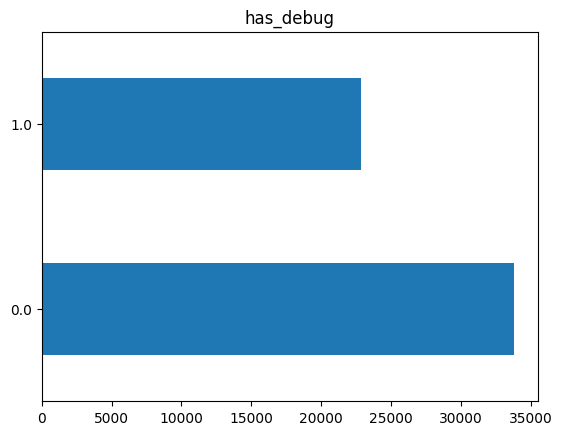

Number of NAN in has_relocations: 3167


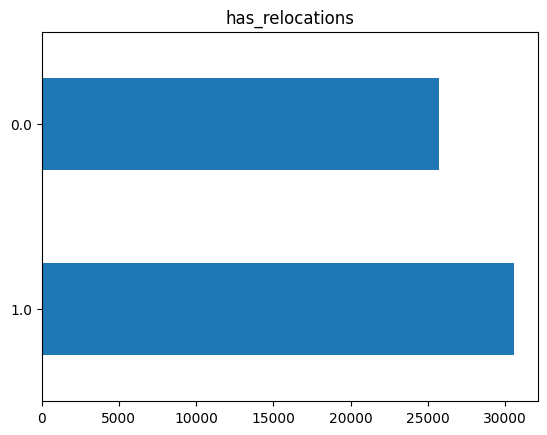

Number of NAN in has_resources: 1886


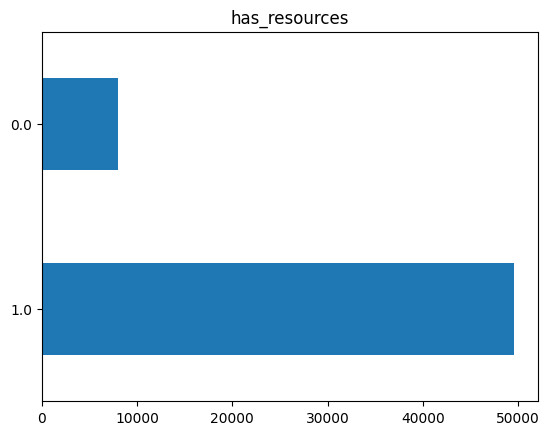

Number of NAN in has_signature: 1846


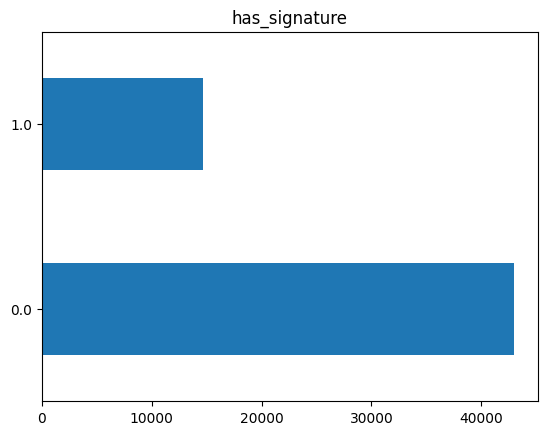

Number of NAN in has_tls: 2765


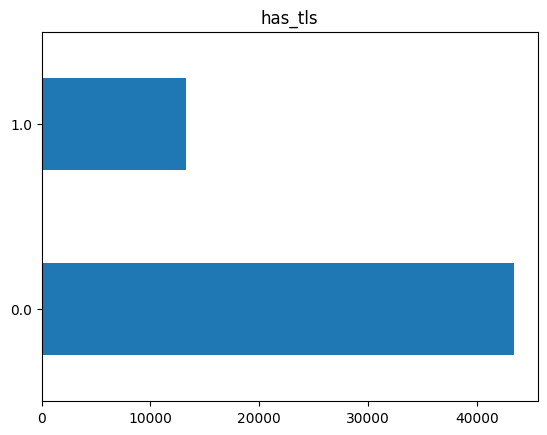

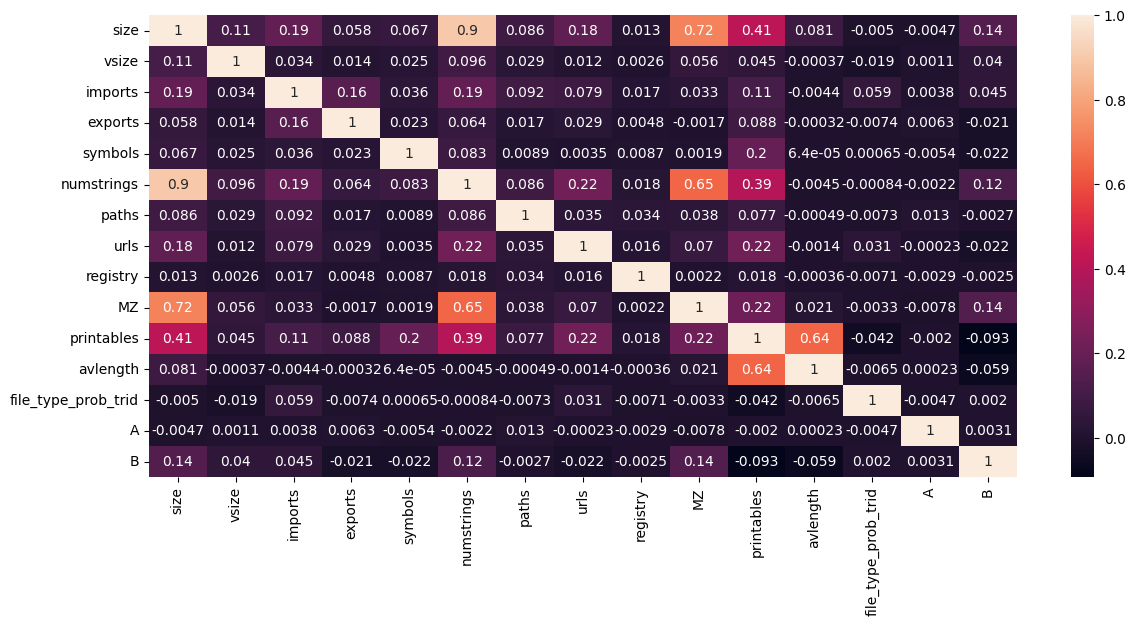

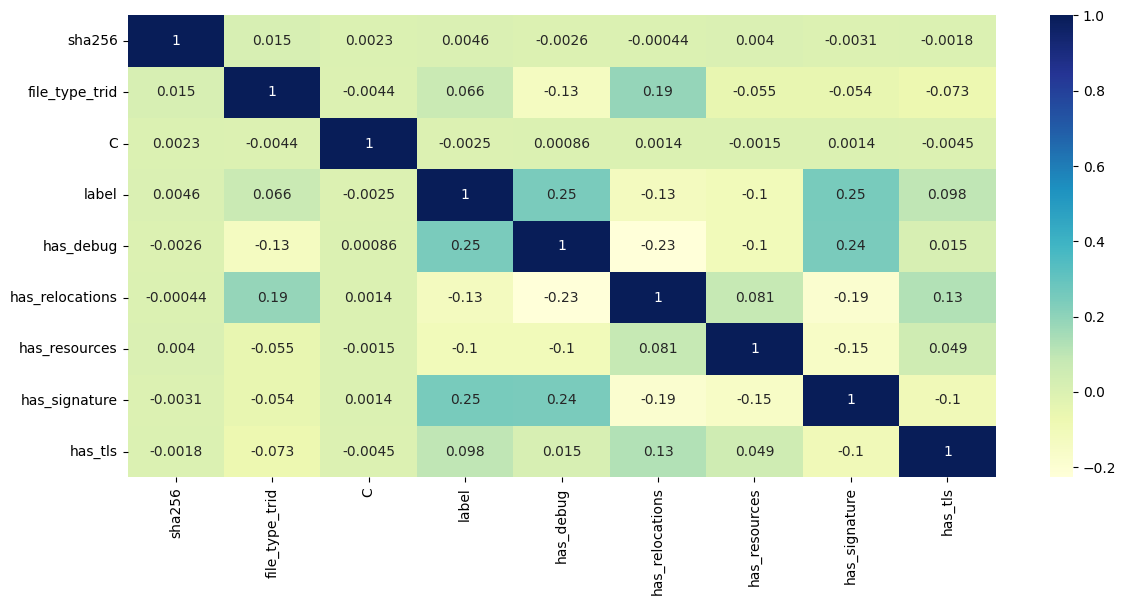

In [4]:
preproccess_train=Import_train_for_preproccessing("train.csv")
Plot_features(preproccess_train)

**<div style="direction:rtl">ניקוי הדאטא - הסרת פיצ'רים</div>**


<div style="direction:rtl"> 

1.שם הקובץ (sha256) - לכל קובץ יש שם אחר ולכן לא ניתן להסיק מסקנות אודות זדוניות הקובץ דרך השם.

2.גודל הקובץ (size) - לגודל הקובץ יש קורלציות חזקות עם שני משתנים נוספים (numstrings, MZ) ולכן החלטנו להסיר פיצ'ר זה, זאת כדי למנוע "רעש" מיותר בהמשך.

3.עמודת הסיווג (label) - לטובת ניתוח ואימון המודל אין לה השפעה ולכן הורדנו אותה.

</div>


<div style="direction:rtl">

כעת ניצור את סט האימון לאחר הורדת הפיצ'רים שצוינו לעיל, נפריד בין סט האימון לעמודת הלייבלים וניצור עותק שלהם על מנת להשוות בהמשך בין סט האימון המקורי לבין סט האימון שעבר תהליך הורדת מימדים:
</div>


In [5]:
def Remove_features_split_train_labels(train_to_split):
    #Creating X_train and Y_train
    final_numeric_features=['vsize', 'imports', 'exports','symbols', 'numstrings', 'paths', 'urls', 'registry', 'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B']
    final_categorial_features=['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls','file_type_trid', 'C']
    train_x=train_to_split[['vsize', 'imports', 'exports', 'has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 'MZ', 'printables', 'avlength', 'file_type_trid', 'file_type_prob_trid', 'A', 'B', 'C']]
    train_y=train_to_split[["label"]]
    X_train_for_pca=train_x.copy()
    return final_numeric_features,final_categorial_features,train_x,train_y,X_train_for_pca

In [6]:
final_numeric_features,final_categorial_features,train_x,train_y,X_train_for_pca=Remove_features_split_train_labels(preproccess_train)
train_y_for_pca=train_y.copy()

**<div style="direction:rtl">חלק שני - עיבוד מקדים</div>**


<div style="direction:rtl"> בתחילה העברנו את הנתונים לפי כל עמודה לגרף המראה את תוצאות המדידות (ויזואליזציה) , לאחר מכן ראינו כי ישנן תוצאות חריגות (outliers). במהלך תהליך העיבוד המקדים ביצענו שני ניסיונות - הנסיון הראשון הוא הסרת התוצאות החריגות והנסיון השני הוא קירוב התוצאות החריגות ללב המעטפת. מטה מתוארים הסברים של שני הנסיונות.

 כדי למנוע את ההשפעות של התוצאות החריגות על המודלים השונים, בניסיון הראשון החלטנו להסיר את התוצאות הנ"ל (מכל עמודה חצי אחוז מהדוגמאות ה"קיצוניות" - הדוגמאות עם הערך הכי גבוה והכי נמוך). חשוב לציין כי במידה וראינו תוצאה חריגה בפיצ'ר מסוים, הסרנו את כל השורה מהדאטה כדי לא להשפיע על המשך המסקנות והמודלים.   
זהו למעשה היה ניסיון להתמודד עם הOutliers. בדיעבד ניסיון זה התברר כניסיון לא מוצלח כי התהליך גרם לסינון של כ-15% מהדאטה ולכן החלטנו לשנות את שיטת הפעולה לקירוב הערכים הקיצוניים ללב המעטפת של הדאטה. השיטה של קירוב התוצאות ללב המעטפת בוצעה ע"י שימוש בפונקציית QUANTILE אשר מקבלת אחוזון לפי הגדרתנו ומחזירה את הערך שמגדיר את הגבול של האחוזון. לאחר מכן, קירבנו את כל התוצאות החריגות לאותו מספר שמצאה הפונקציה. כלומר, כלל הדוגמאות עם ערך קיצוני קורבו לדוגמא הקרובה ביותר לפי האחוזון שבחרנו חשוב להדגיש כי הניסיון הראשון הוא לטובת הניסיון בלבד ואין לו מקום בWork Flow הסופי.

ההחלטה איך על איך לבצע את הקירוב בוצעה אל מול התפלגות הדאטה בכל פיצ'ר, לדוגמה במידה וראינו שהדוגמאות החריגות נמצאות רק בקיצון אחד של הדאטה (לדוגמה רק בחלק העליון של הדאטה- באחוזון ה99) אזי הקירוב בוצע רק לחלק העליון, כל דוגמה שערכה היה גבוה מערך האחוזון שנקבע - ערכה שונה לערך האחוזון.

ניתוח זה בוצע עבור כל פיצ'ר ומדיניות הפעולה שהתקבלה מופיעה בקוד מטה.
   </div>


In [7]:
# Code of dealing with outliers that didnt turn out to be successfull - will not be a part of the final workflow
def first_try_outliers(X_reduced_train):
    for feature in final_numeric_features:
        #plotting graph
        plt.figure(figsize=(12,8))
        plt.title(feature)
        plt.yscale("log")
        sns.scatterplot(data=train_x,x=train_x["index_col"],y=feature)
        plt.show()

        lower_quantile_level =int(0.005 * train_x.shape[0])
        upper_quantile_level =int(0.995 * train_x.shape[0])
        
        #cutting top quantile
        train2=X_reduced_train.sort_values(feature, ascending=True)
        train2 = train2.reset_index(drop=True)
        X_reduced_train=train2[(train2[feature].index>lower_quantile_level)].copy()
        train_y=train_y[(train2[feature].index>lower_quantile_level)].copy()
    
        #cutting bottom quantile
        train2=X_reduced_train.sort_values(feature, ascending=False)
        train2 = train2.reset_index(drop=True)
        X_reduced_train=train2[(train2[feature].index>lower_quantile_level)].copy()
        train_y=train_y[(train2[feature].index>lower_quantile_level)].copy()

        #plotting new graph
        plt.figure(figsize=(12,8))
        plt.title("new {0}".format(feature))
        sns.scatterplot(data=X_reduced_train,x=X_reduced_train["index_col"],y=feature)
        plt.yscale("log")
        plt.show()
        sns.displot(data=X_reduced_train,x=X_reduced_train[feature],kind="kde")
        plt.show()

In [8]:
def quantile_outliers_to_limit_and_plot(train_x,num):

    # Dealing with vsize outliers 
    # winorsizing from top and bottom of data
    top_limit = train_x["vsize"].quantile(0.99)
    bottom_limit = train_x["vsize"].quantile(0.01)
    train_x.loc[train_x["vsize"] > top_limit, "vsize"] = top_limit
    train_x.loc[train_x["vsize"] < bottom_limit, "vsize"] = bottom_limit
    if num==1:
        plt.hist(train_x["vsize"], bins=20)
        plt.title("vsize after winsorize")
        plt.yscale("log")
        plt.show()

    # Dealing with imports outliers
    # winorsizing from top of data
    top_limit = train_x["imports"].quantile(0.95)
    train_x.loc[train_x["imports"] > top_limit, "imports"] = top_limit
    if num==1:
        plt.hist(train_x["imports"], bins=20)
        plt.title("imports after winsorize")
        plt.yscale("log")
        plt.show()

    # Dealing with paths outliers
    # winorsizing from top of data
    top_limit = train_x["paths"].quantile(0.99)
    train_x.loc[train_x["paths"] > top_limit, "paths"] = top_limit
    if num==1:
        plt.hist(train_x["paths"], bins=20)
        plt.title("paths after winsorize")
        plt.yscale("log")
        plt.show()

    # Dealing with urls outliers
    # winorsizing from top of data
    top_limit = train_x["urls"].quantile(0.99)
    train_x.loc[train_x["urls"] > top_limit, "urls"] = top_limit
    if num==1:
        plt.hist(train_x["urls"], bins=20)
        plt.title("urls after winsorize")
        plt.yscale("log")
        plt.show()

    # Dealing with registry outliers
    # winorsizing from top of data
    top_limit = train_x["registry"].quantile(0.99)
    train_x.loc[train_x["registry"] > top_limit, "registry"] = top_limit
    if num==1:
        plt.hist(train_x["registry"], bins=20)
        plt.title("registry after winsorize")
        plt.yscale("log")
        plt.show()

    # Dealing with MZ outliers
    # winorsizing from top of data
    top_limit = train_x["MZ"].quantile(0.99)
    train_x.loc[train_x["MZ"] > top_limit, "MZ"] = top_limit
    if num==1:
        plt.hist(train_x["MZ"], bins=20)
        plt.title("MZ after winsorize")
        plt.yscale("log")
        plt.show()

    # Dealing with printables outliers
    # winorsizing from top and bottom of data
    top_limit = train_x["printables"].quantile(0.99)
    bottom_limit = train_x["printables"].quantile(0.01)
    train_x.loc[train_x["printables"] > top_limit, "printables"] = top_limit
    train_x.loc[train_x["printables"] < bottom_limit, "printables"] = bottom_limit
    if num==1:
        plt.hist(train_x["printables"], bins=20)
        plt.title("printables after winsorize")
        plt.yscale("log")
        plt.show()

    # Dealing with avlength outliers
    # winorsizing from top of data
    top_limit = train_x["avlength"].quantile(0.99)
    train_x.loc[train_x["avlength"] > top_limit, "avlength"] = top_limit
    if num==1:
        plt.hist(train_x["avlength"], bins=20)
        plt.title("avlength after winsorize")
        plt.yscale("log")
        plt.show()

    # No action taken for exports, symbols, numstrings, file_type_prob_trid, A, and B outliers

    return train_x


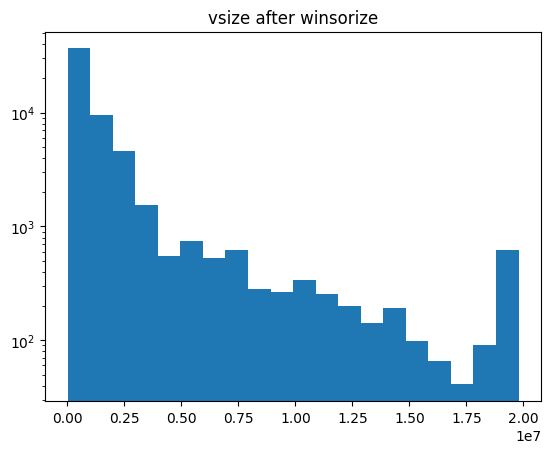

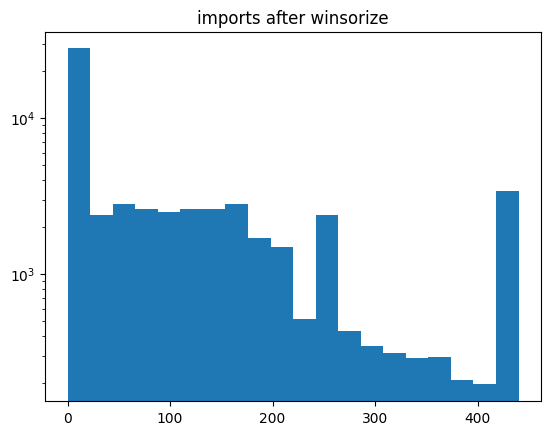

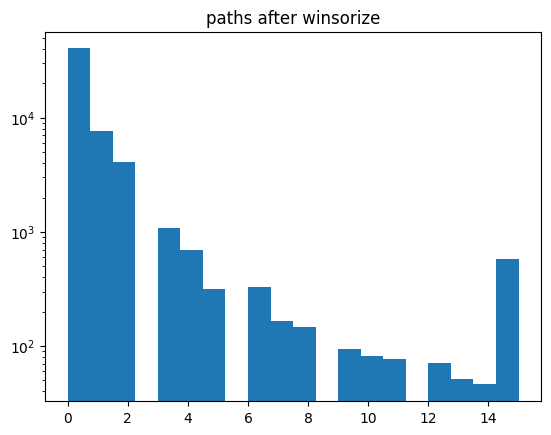

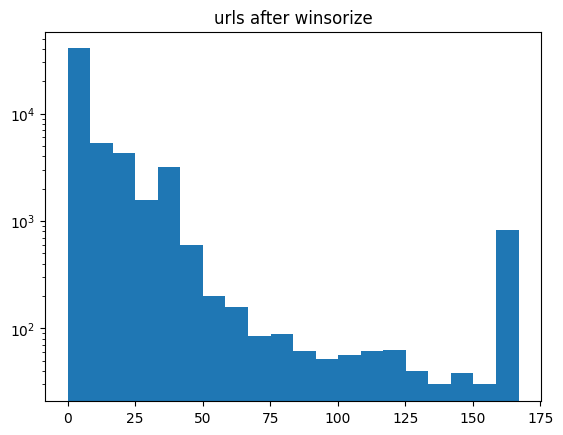

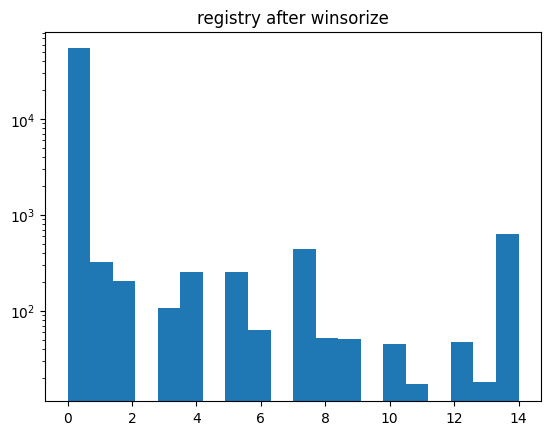

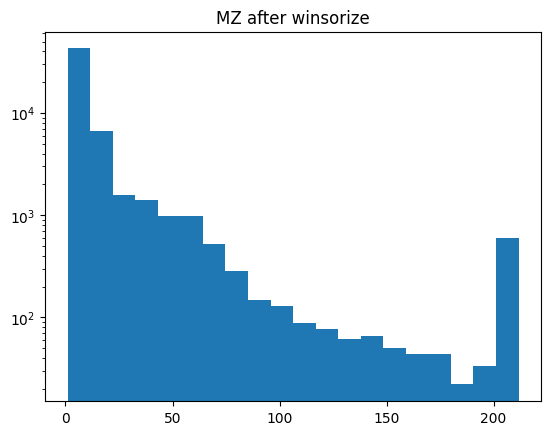

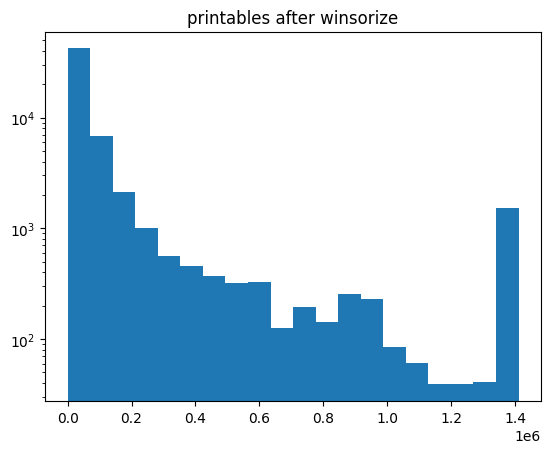

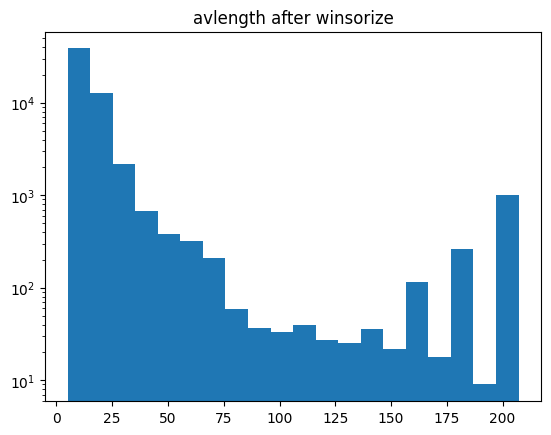

In [9]:
train_x=quantile_outliers_to_limit_and_plot(train_x,1)
X_train_for_pca=quantile_outliers_to_limit_and_plot(X_train_for_pca,2)

**<div style="direction:rtl">התמודדות עם נתונים חסרים - משתנים נומריים</div>**

<div style="direction:rtl">בכלל הפיצ'רים למעט sha256, file_type_trid חסרים ערכי תוצאות. כדי להתמודד עם החוסר בנתונים בחרנו להתאים לכל פיצר את שיטת ההשלמה המתאימה לו ביותר.
משתנים נומרים:

1.	Vsize  - לפי שיטת KNN והחלטה לפי ערכי numstrings בעקבות קורלציה גבוהה בין המשתנים.

2.	Imports – בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.

3.	Exports - בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.

4.	Symbols - בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.

5.	Numstrings - לפי שיטת KNN והחלטה לפי ערכי MZ בעקבות קורלציה גבוהה בין המשתנים.

6.	Paths - בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.

7.	Urls - בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.

8.	Registry - בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.

9.	MZ - לפי שיטת KNN והחלטה לפי ערכי numstrings בעקבות קורלציה גבוהה בין המשתנים.

10.	Printables - לפי שיטת KNN והחלטה לפי ערכי avlength בעקבות קורלציה גבוהה בין המשתנים.

11.	Avlength - לפי שיטת KNN והחלטה לפי ערכי printables בעקבות קורלציה גבוהה בין המשתנים.

12.	File_type_prob_trid - בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.

13.	A - בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.

14.	B - בעקבות חוסר בקורלציה גבוהה (מעל 0.5) עם אף אחד מהפיצ'רים האחרים החלטנו על שיטת ממוצע לטובת השלמת הערכים החסרים.
</div>

In [10]:
def fill_empty_numeric_features(train_x,train_y):
    #reshaping train_y to fit it for later uses 
    train_y=np.array(train_y)
    train_y=train_y.reshape(train_y.shape[0],1)
    train_y=pd.DataFrame(train_y)

    #Filling NaN values by column mean - iterating over features to fill by mean
    for col in ["imports","exports","symbols","paths","urls","registry","file_type_prob_trid","A","B"]:
        #calculating column mean
        col_mean=train_x[col].mean()
        #filling NaN values in train_x
        train_x[col].fillna(col_mean,inplace=True)
    
    np.random.seed(0)
    #initializing a knn model do find NAN values in one column, 
    #then finds the 5 nearest neighbors in the other columns and calculates their mean in the origional column and inserts to the NAN cell
    Knn_model=KNNImputer(n_neighbors=5,weights="distance")
    filled=Knn_model.fit_transform(train_x[["printables","avlength"]])
    train_x[["printables","avlength"]]=filled
    
    np.random.seed(0)
    #initializing a knn model do find NAN values in one column, 
    #then finds the 5 nearest neighbors in the other columns and calculates their mean in the origional column and inserts to the NAN cell
    Knn_model=KNNImputer(n_neighbors=5,weights="distance")
    filled=Knn_model.fit_transform(train_x[["MZ","numstrings"]])
    train_x[["MZ","numstrings"]]=filled
    
    np.random.seed(0)
    #initializing a knn model do find NAN values in one column, 
    #then finds the 5 nearest neighbors in the other columns and calculates their mean in the origional column and inserts to the NAN cell
    Knn_model=KNNImputer(n_neighbors=5,weights="distance")
    filled=Knn_model.fit_transform(train_x[["vsize","numstrings"]])
    train_x[["vsize","numstrings"]]=filled
    return train_x,train_y


In [11]:
train_x,train_y=fill_empty_numeric_features(train_x,train_y)
X_train_for_pca,train_y_for_pca=fill_empty_numeric_features(X_train_for_pca,train_y_for_pca)

**<div style="direction:rtl">התמודדות עם נתונים חסרים - משתנים קטגוריאליים</div>**

<div style="direction:rtl">
משתנים קטגוריאלים: כדי להתמודד עם המשתנים הקטגוריאלים בחרנו בשתי שיטות על מנת למלא את הערכים החסרים. השיטה הראשונה הינה מילוי ערכים חסרים לפי הערך התדיר ביותר בשאר העמודה. השיטה השנייה הינה שמירה על היחס בין התוצאות האפשריות.

מדיניות בחירה בין השיטות:   

1.	Has_debug – מכיוון שהיחס בין התוצאות מתקרב לחצי (משמע אינו משמעותי) נרצה לשמור על היחס בין התוצאות ולכן נמלא באקראיות את הערכים החסרים ב-0 או 1 כך שאחוז האפסים יהיה זהה לאחוז האחדות לפני ההוספה. נחשב את אחוז האפסים מכלל הדוגמאות שבעלות ערכים, ואז נכפיל את האחוז הזה במספר הערכים הכולל (מס' הדוגמאות הכולל), כך נדע את כמות האפסים הנדרשת כדי לשמור על היחסים. נציב באופן אקראי את כמות האפסים שתשלים לכמות שחושבה, ושאר הערכים החסרים יקבלו ערך 1.

2.	Has_relocation – מכיוון שהיחס בין התוצאות מתקרב לחצי (משמע אינו משמעותי) נרצה לשמור על היחס בין התוצאות ולכן נמלא באקראיות את הערכים החסרים ב-0 או 1 כך שאחוז האפסים יהיה זהה לאחוז האחדות לפני ההוספה. נחשב את אחוז האפסים מכלל הדוגמאות שבעלות ערכים, ואז נכפיל את האחוז הזה במספר הערכים הכולל (מס' הדוגמאות הכולל), כך נדע את כמות האפסים הנדרשת כדי לשמור על היחסים. נציב באופן אקראי את כמות האפסים שתשלים לכמות שחושבה, ושאר הערכים החסרים יקבלו ערך 1.

3.	Has_resources – נשלים לפי הערך השכיח ביותר (1).

4.	Has_signature – נשלים לפי הערך השכיח ביותר (0).

5.	Has_tls – נשלים לפי הערך השכיח ביותר (0).

6.	File_type_trid – אין ערכים חסרים – אין צורך בטיפול.

7.	C – אמנם יש מספר של ערכים אך הערך השכיח ביותר בפער משמעותי הינו vh, לכן בחרנו למלא את כל הערכים החסרים לפי vh.
</div>

In [12]:
def fill_empty_categoric_features(train_x,X_reduced_train,train_y,final_categorial_features,num):
    #filling the NA with the most frequent value
    for col in ["has_resources","has_signature","has_tls","C"]:
        max_val_list=X_reduced_train[col].value_counts().index
        train_x[col]=X_reduced_train[col].fillna(max_val_list[0])
    if num ==1:
        #Plotting historigrams for each binary feature
        for cat_feature in final_categorial_features:
            X_reduced_train[cat_feature].value_counts().head(20).plot.barh()
            plt.title(cat_feature)
            print("Number of NAN in feature {0} after filling:".format(cat_feature), train_x[cat_feature].isna().sum())
            plt.show()
        
    #filling teh NA of has_debug and has_relocations features such that the ratio between 0 and 1 remains the same before and after the filling
    for feature in ["has_debug","has_relocations"]:
        # Finding all of the zeros and ones
        zeros_indices = np.where(X_reduced_train[feature] == 0)[0]
        ones_indices = np.where(X_reduced_train[feature] == 1)[0]

        # Counting the number of zeros and ones
        zeros_amount = zeros_indices.shape[0]
        ones_amount = ones_indices.shape[0]

        # Percent of zeros in the filled data only
        zeros_amount_percent = zeros_amount / (zeros_amount + ones_amount)

        # Percent of zeros in all of the data (with NaN)
        total_zeros = int(zeros_amount_percent * X_reduced_train.shape[0])

        # Amount of zeros to be inserted into the column
        zeros_to_fill = total_zeros - zeros_amount

        # Randomly choose indices of NaN values to fill with zeros
        nan_indices = X_reduced_train[X_reduced_train[feature].isna()].index.tolist()
        
        random.seed(0)
        indices_fill_zero = random.sample(nan_indices, k=zeros_to_fill)
        train_x.loc[indices_fill_zero, feature] = 0
        
        # Fill remaining NaN values with ones
        train_x[feature].fillna(1, inplace=True)


    if num ==1:
        #Plotting historigrams for each categoric feature
        for cat_feature in final_categorial_features:
            X_reduced_train[cat_feature].value_counts().head(20).plot.barh()
            plt.title(cat_feature)
            print("Number of NAN in feature {0} after filling:".format(cat_feature), train_x[cat_feature].isna().sum())
            plt.show()
        
    return train_x,train_y

Number of NAN in feature has_debug after filling: 2808


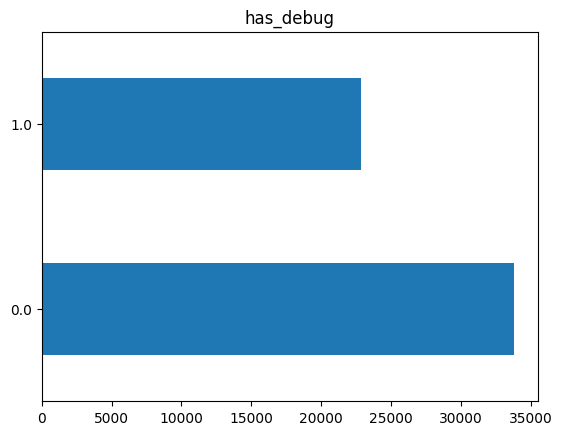

Number of NAN in feature has_relocations after filling: 3167


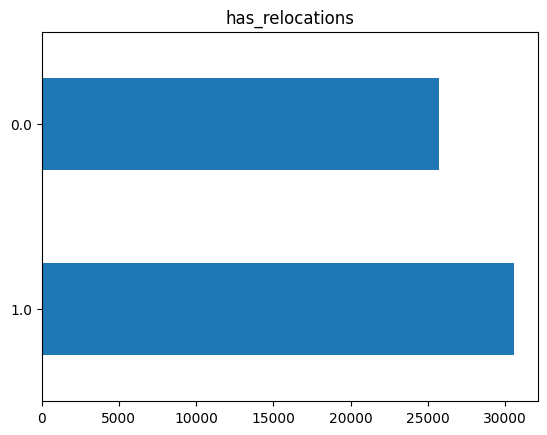

Number of NAN in feature has_resources after filling: 0


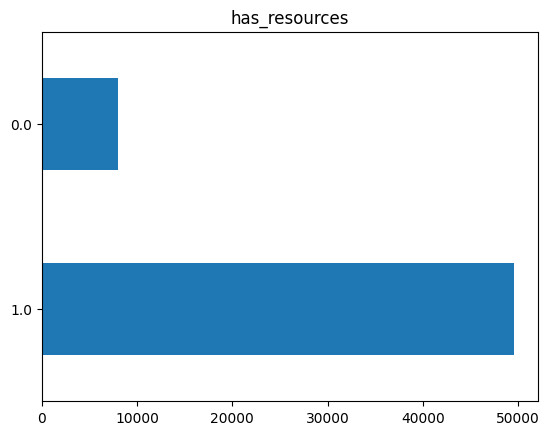

Number of NAN in feature has_signature after filling: 0


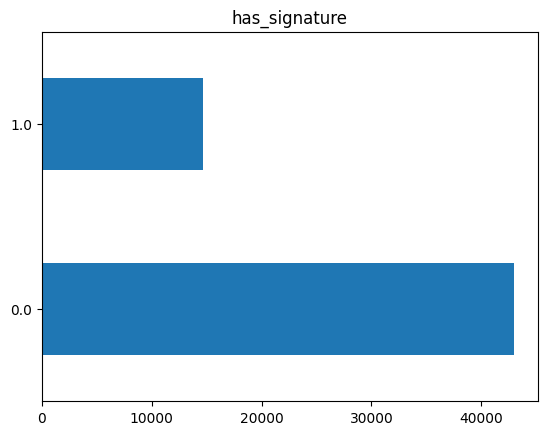

Number of NAN in feature has_tls after filling: 0


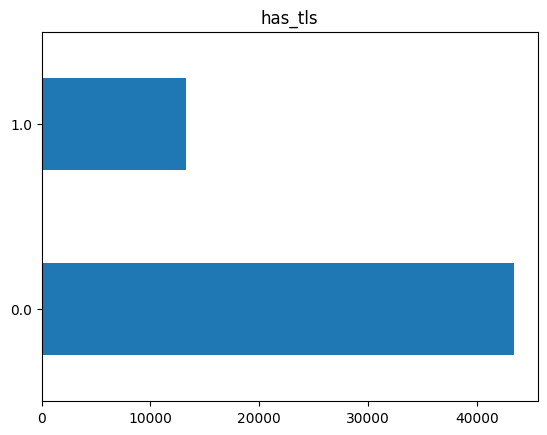

Number of NAN in feature file_type_trid after filling: 0


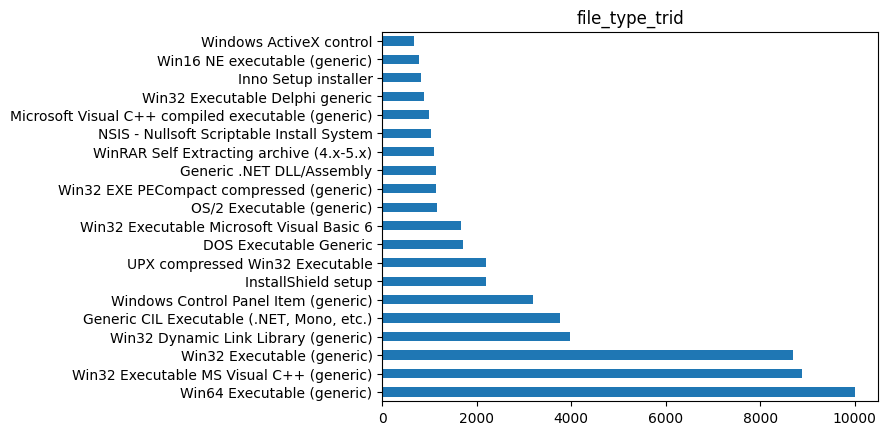

Number of NAN in feature C after filling: 0


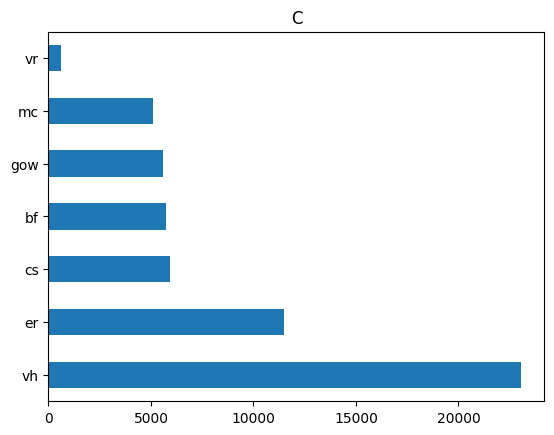

Number of NAN in feature has_debug after filling: 0


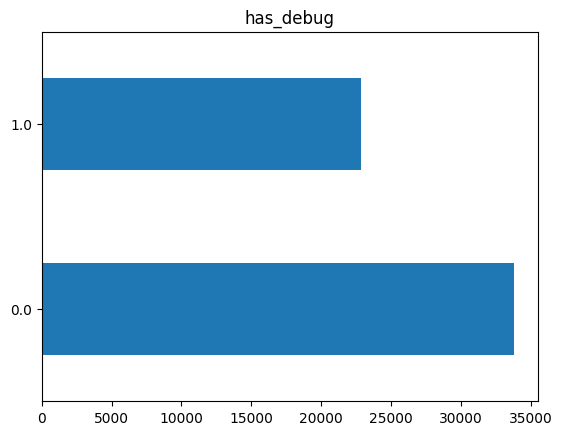

Number of NAN in feature has_relocations after filling: 0


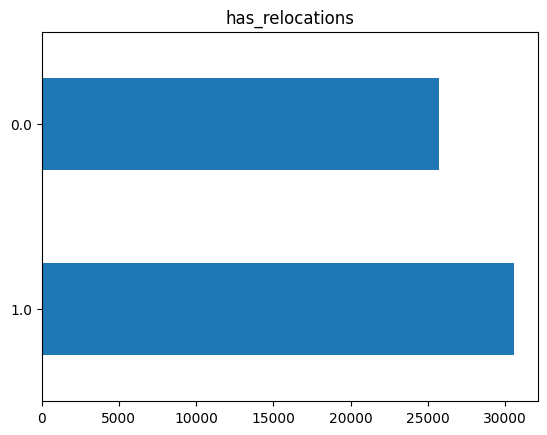

Number of NAN in feature has_resources after filling: 0


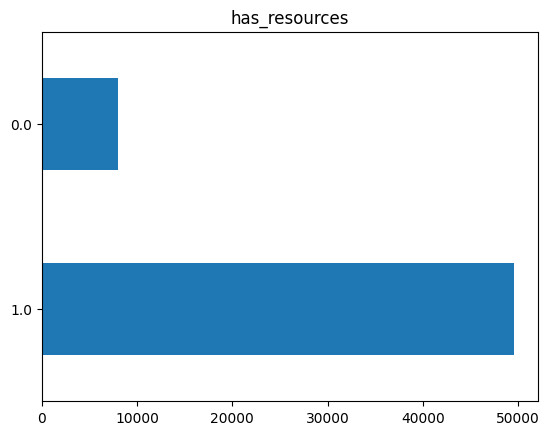

Number of NAN in feature has_signature after filling: 0


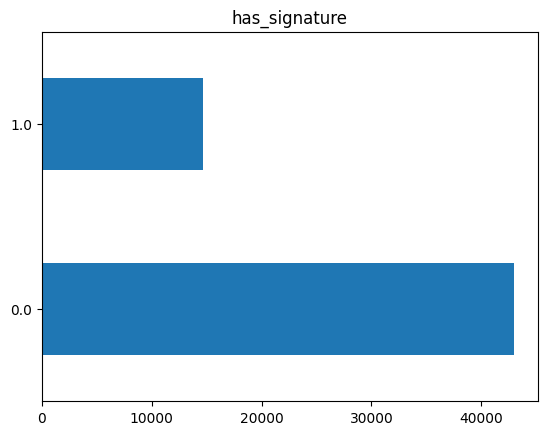

Number of NAN in feature has_tls after filling: 0


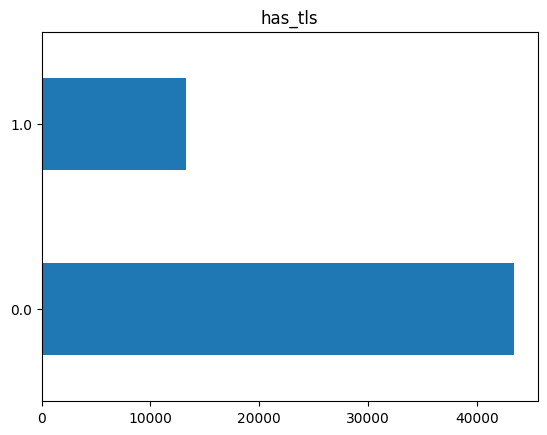

Number of NAN in feature file_type_trid after filling: 0


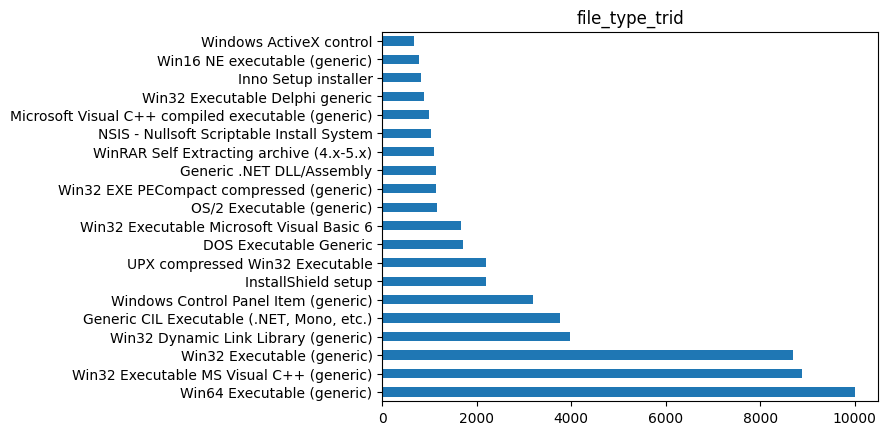

Number of NAN in feature C after filling: 0


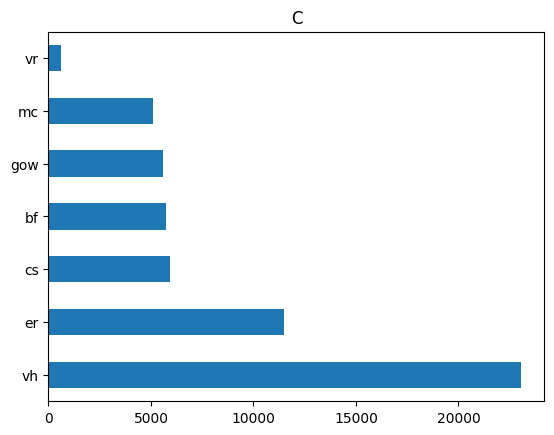

In [13]:
train_x,train_y=fill_empty_categoric_features(train_x,train_x.copy(),train_y,final_categorial_features,1)
X_train_for_pca,train_y_for_pca=fill_empty_categoric_features(X_train_for_pca,X_train_for_pca.copy(),train_y_for_pca,final_categorial_features,2)

**<div style="direction:rtl"> נרמול הנתונים</div>**

<div style="direction:rtl"> כפי שניתן לראות בגרפים מעלה, ישנם נתונים לא מנורמלים. לנרמול הנתונים יש מספר השפעות על בניית המודלים ובפתרון הבעיה בהמשך ולכן נצטרך לנרמל את הנתונים.
ההשפעה הראשונה הינה התמודדות עם קנה מידה שונים של הנתונים (Scaling) אשר באה לבטל את השפעת גודל נתוני פיצ'ר מסוים על תוצאה סופית של המודל. כלומר אם ערכי הנתון גבוהים מאוד, המודל לא יושפע מערכים אלו בצורה קיצונית.
השפעה שנייה, התמודדות עם Outliers. כאשר מנרמלים את הנתונים, כלל התוצאות מתכנסות בין 0 ל-1. כלומר ערכים קיצוניים מאוד מתכנסים לתחום מצומצם מאוד ובכך נוצר מודל יותר אמין כתוצאה מצמצום השפעות של הנתונים הקיצוניים.
השפעה שלישית, השוואת ערכים. הנרמול מאפשר להשוות בין ערכי פיצ'רים שונים באופן מדויק יותר בפתרון הבעיה ובכך אפשר להבין מה חשיבותו (ומה תרומתו) של כל פיצ'ר בבעיה.
</div>


In [14]:
def Encoding_and_Normalization_of_data(train_x):
    # creating a copy of train_x to binary encode the nominal columns (have strings in them)
    encoded_train = train_x.copy()
    print(encoded_train.shape)
    # nominal columns to encode
    columns_to_encode = ["file_type_trid", "C"]

    # initialize a binaryencoder 
    encoder = ce.BinaryEncoder(cols=columns_to_encode)
    #encoding the columns
    encoded_columns = encoder.fit_transform(encoded_train[columns_to_encode])

    # dropping the old nominal columns from encoded_train
    encoded_train.drop(columns_to_encode, axis=1, inplace=True)
    # Concatenate the encoded columns with the remaining train data
    encoded_train = pd.concat([encoded_train, encoded_columns], axis=1)

    #saving a copy of encoded train to use it for building later a new feature
    encoded_train_before_norm=encoded_train.copy()

    #initialize MinMaxScaler normalizer model and normalizing the encoded train
    norm_model=MinMaxScaler(feature_range=(0,1))
    encoded_train=norm_model.fit_transform(encoded_train)
    
    return encoded_train,encoded_train_before_norm

In [15]:
encoded_train,encoded_train_before_norm=Encoding_and_Normalization_of_data(train_x)
encoded_train_before_pca,encoded_train_for_pca_before_norm=Encoding_and_Normalization_of_data(X_train_for_pca)

(59486, 21)


(59486, 21)


**<div style="direction:rtl">מימדיות הבעיה</div>**

<div style="direction:rtl">

מימדיות הבעיה מתבטאת בכמות הפיצ'רים שמשתמשים בהם להערכת המודל. למימדיות גבוהה יש מספר חסרונות:

1.קללת המימדיות – ככל שמימדיות הבעיה גדלה, הדאטה נפרש בצורה בה המרחק בין הנקודות גדול, דבר העלול להוביל לפספוס קשרים קיימים ואף למסקנות לא נכונות. למעשה, קשה יותר להעביר מסווגים במרחב ותוצאות המודל יהיו לא טובות.

2.עלות חישובית - ככל שמימדיות הבעיה גבוהה יותר אזי זמן ניתוח וחישוב של הבעיה גדל. חישוב המסווגים מבוצע בזמן ארוך יותר ולכן המודל הופך למודל לא יעיל חישובית. 

3.OVERFITTING - ככל שמימדיות הבעיה גדלה, המודל יכול לבצע התאמה מושלמת לכל דוגמא ובכך שגיאת המבחן יורדת משמעותית, אך בפועל המודל "משנן" תוצאות ולא יודע להתמודד עם דאטה חדש באופן נכון . 

</div>

<div style="direction:rtl">

אפשר לזהות את בעיית המימדיות בשלוש דרכים:


1.חישוביות זמן ריצה - ברגע שזמן הריצה גדול מאוד, הדבר מעלה חשד כי המודל משתמש בהרבה פיצ'רים שלא תמיד מועילים על מנת לקבוע סיווג/תוצאה.

2. תוצאות המודל – במידה והבעיה עוסקת במספר מימדים ותוצאות המודל מראות תוצאות לא טובות, עלינו לחשוד במצב של OVERFITTING. הדבר סביר מאוד ולכן הוא הראשון שצריך להילקח בחשבון בעיסוק במספר של מימדים.

3. שימוש בסט ולידציה- ניתן לפצל את סט האימון לסטים קטנים כאשר כל פעם אחד אחר מהם ישמש כסט ולידציה שעליו ננבא תוצאות לאחר שימוש בשאר הסטים כסט אימון. במידה וציון המודל אינו יציב ועקבי ניתן לחשוד כי יש יותר מידי פיצ'רים שמשפיעים כל פעם באופן שונה על תוצאת הניבוי. 


</div>

<div style="direction:rtl"> 
בדו"ח המצורף נעמיק בבעיית המימדיות והשפעת מספר המימדים על המודלים בחלק שלישי - הרצת מודלים בעקבות מסקנות שהוסקו בדיעבד לאחר הרצה ראשונית.
</div>

**<div style="direction:rtl">הקטנת המימדיות בעזרת טכניקת PCA</div>**

<div style="direction:rtl">PCA הינה שיטה להורדת גודל מימדיות הבעיה זאת על ידי שתי אופציות: 

1.שימוש במספר שלם - קביעת מספר פיצ'רים מסויים שזהו מספר המימדים שאליו נרצה להגיע.

2. בחירות אחוז השונות המוסברת - נקבע אחוז שונות שאותו נרצה להסביר בעזרת הנתונים, והמודל יבחר לאיזה מימד לרדת כדי להגיע לאחוז השונות הנ"ל.

בשתי האופציות שיטה זו שומרת על הפיצ'רים החשובים ביותר ובעזרתם בונה מודל ממימד נמוך יותר אשר יעיל יותר חישובית. אמנם יש איבוד מידע אך הדבר מאפשר להגיע למודל מהיר יותר ובאחוזים גבוהים קרוב למודל המקורי לפני הורדת המימדים.
</div>

In [16]:
def encoding_train_pca_reduction(encoded_train):
    #creating a copy of unreducted encoded train for later model evaluation
    unreducted_encoded_train=encoded_train.copy()
    print(encoded_train.shape)
    print(unreducted_encoded_train.shape)
    #intialize pca model
    pca=PCA(0.99)
    #looking what the dimentions of encoded_train before reducing
    print("encoded_train dimensions before PCA reduction:",encoded_train.shape[1])
    #dimension reduction
    encoded_train_reduced=pca.fit_transform(encoded_train)
    #looking what the dimentions of encoded_train after reducing
    print("encoded_train dimensions after PCA reduction:",len(pca.components_))
    return encoded_train,encoded_train_reduced

In [17]:
store,encoded_train_after_pca=encoding_train_pca_reduction(encoded_train_before_pca)


(59486, 29)
(59486, 29)
encoded_train dimensions before PCA reduction: 29


encoded_train dimensions after PCA reduction: 22


**<div style="direction:rtl">בניית פיצ'ר חדש</div>**

<div style="direction:rtl">לטובת הקטנת כמות המשתנים כמו בשיטת הPCA נרצה לבנות פיצ'ר חדש. את הפיצ'ר החדש ניצור בעזרת שני פיצ'רים קיימים: imports,exports. המשתנה יקרא interface_outside_world. משמעותו היא מידת הממשק של הקובץ עם העולם החיצון, משמע כמות הנתונים המיובאים אליו והיוצאים ממנו.
לדעתינו ככל שהפיצ'ר יותר מחובר לעולם החיצון יש סיכוי גבוה יותר שהוא עלול להיות זדוני מכיוון שהוא עלול להידבק או להדביק קבצים אחרים דרך הייבוא והייצוא.
נחבר בין ערכי הimport והexport וננרמל את העמודה מחדש.</div>

In [18]:
def Add_new_feature(encoded_train_before_norm):
    #creating a copy of a copy of encoded train before normalization and using the copy of the encoded train and on it building a new feature
    encoded_train_new_feature=encoded_train_before_norm.copy()
    #initializing a normalization model then building the new feature and normalizing the whole data once
    norm_model=MinMaxScaler(feature_range=(0,1))
    encoded_train_new_feature["interface_outside_world"]=encoded_train_before_norm["exports"]+encoded_train_before_norm["imports"]
    encoded_train_new_feature=norm_model.fit_transform(encoded_train_new_feature)

In [19]:
Add_new_feature(encoded_train_before_norm)

**<div style="direction:rtl">עיבוד מקדים לסט ה-TEST</div>**

<div style="direction:rtl">עיבוד הדאטה אותו אנחנו מקבלים בTEST חשוב לטובת החלת המודלים על הנתונים בהמשך. לטובת זאת, מילאנו את כלל הנתונים החסרים בשורות התוצאות השונות, הן במשתנים הנומריים והן במשתנים הקטגוריאליים ע"פ השיטות ומדיניות בחירת הנתונים אותן קבענו בסט הTRAIN. בנוסף, נירמלנו את הדאטה זאת לטובת החלת המודלים השונים בהמשך ללא בעיה. 
כעת אנחנו יכולים לקבל כל TEST SET ולהשלים את החוסרים לטובת הסקת המסקנות.

העיבוד על TEST SET מבוצע בשלב זה ומיושם בחלק חמש - ביצוע פרדיקציה.<div>

In [20]:
def Preproccessing_test(raw_test_set):
    raw_test_set=pd.read_csv(raw_test_set)
    test_set_names=raw_test_set.copy()
    test_set_names=test_set_names["sha256"]
    #dropping features that dont affect the predictions (those columns also removed in the preproccessing of the train set)
    raw_test_set.drop(["sha256","size"],axis=1,inplace=True)

    #lists of features seperated by numeric and categorial
    final_numeric_features=['vsize', 'imports', 'exports','symbols', 'numstrings', 'paths', 'urls', 'registry', 'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B']
    final_categorial_features=['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls','file_type_trid', 'C']

    #filling Na in testset by the methods learned on the train set - numeric columns
    #Filling NaN values by column mean - iterating over features to fill by mean
    for col in ["imports","exports","symbols","paths","urls","registry","file_type_prob_trid","A","B"]:
        #calculating column mean
        col_mean=raw_test_set[col].mean()
        #filling NaN values in raw_test_set
        raw_test_set[col].fillna(col_mean,inplace=True)

    np.random.seed(0)
    #initializing a knn model do find NAN values in one column, 
    #then finds the 5 nearest neighbors in the other columns and calculates their mean in the origional column and inserts to the NAN cell
    Knn_model=KNNImputer(n_neighbors=5,weights="distance")
    filled=Knn_model.fit_transform(raw_test_set[["printables","avlength"]])
    raw_test_set[["printables","avlength"]]=filled
    
    np.random.seed(0)
    #initializing a knn model do find NAN values in one column, 
    #then finds the 5 nearest neighbors in the other columns and calculates their mean in the origional column and inserts to the NAN cell
    Knn_model=KNNImputer(n_neighbors=5,weights="distance")
    filled=Knn_model.fit_transform(raw_test_set[["MZ","numstrings"]])
    raw_test_set[["MZ","numstrings"]]=filled
    
    np.random.seed(0)
    #initializing a knn model do find NAN values in one column, 
    #then finds the 5 nearest neighbors in the other columns and calculates their mean in the origional column and inserts to the NAN cell
    Knn_model=KNNImputer(n_neighbors=5,weights="distance")
    filled=Knn_model.fit_transform(raw_test_set[["vsize","numstrings"]])
    raw_test_set[["vsize","numstrings"]]=filled


    #filling the missing values in the test set
    for col in ["has_resources","has_signature","has_tls","C"]:
        max_val_list=raw_test_set[col].value_counts().index
        raw_test_set[col]=raw_test_set[col].fillna(max_val_list[0])

    #filling the missing values in the test set of columns has_debug and has_relocations
    for feature in ["has_debug","has_relocations"]:
        # Finding all of the zeros and ones
        zeros_indices = np.where(raw_test_set[feature] == 0)[0]
        ones_indices = np.where(raw_test_set[feature] == 1)[0]

        # Counting the number of zeros and ones
        zeros_amount = zeros_indices.shape[0]
        ones_amount = ones_indices.shape[0]

        # Percent of zeros in the filled data only
        zeros_amount_percent = zeros_amount / (zeros_amount + ones_amount)

        # Percent of zeros in all of the data (with NaN)
        total_zeros = int(zeros_amount_percent * raw_test_set.shape[0])

        # Amount of zeros to be inserted into the column
        zeros_to_fill = total_zeros - zeros_amount

        # Randomly choose indices of NaN values to fill with zeros
        nan_indices = raw_test_set[raw_test_set[feature].isna()].index.tolist()
        random.seed(0)
        indices_fill_zero = random.sample(nan_indices, k=zeros_to_fill)
        raw_test_set.loc[indices_fill_zero, feature] = 0

        # Fill remaining NaN values with ones
        raw_test_set[feature].fillna(1, inplace=True)


    #creating a variable that represents the filled test set without NAN
    full_test_set=raw_test_set.copy()
    #creating a copy of the full test set and encoding the nominal columns
    encoded_test = full_test_set.copy()

    #columns that are nominal and need to be encoded
    columns_to_encode = ["file_type_trid", "C"]
    #initializing a binary encoder model
    encoder = ce.BinaryEncoder(cols=columns_to_encode)
    #binary encoding the columns
    encoded_columns = encoder.fit_transform(encoded_test[columns_to_encode])
    #dropping the old columns that are not encoded
    encoded_test.drop(columns_to_encode, axis=1, inplace=True)
    #Concatenate the encoded columns with the rest of the test set
    encoded_test = pd.concat([encoded_test, encoded_columns], axis=1)

    #initialize MinMaxScaler normalizer model
    test_after_norm=encoded_test.copy()
    print(encoded_test.shape)
    #normalization
    norm_model=MinMaxScaler(feature_range=(0,1))
    test_after_norm=norm_model.fit_transform(test_after_norm)
    return test_after_norm,test_set_names


**<div style="direction:rtl">חלק שלישי - הרצת המודלים</div>**

<div style="direction:rtl">בניית הTRAIN SET והVALIDATION SET מחדש למען אימון המודלים</div>

In [21]:
def Import_train_for_modeling(file_name):
    #importing training set
    train_visual_set=pd.read_csv(file_name)
    #creating a copy the dataset
    cleaned_train_set=train_visual_set.copy()
    return cleaned_train_set

In [22]:
#import dataset 
dataset=Import_train_for_modeling("train.csv")
#removing the unwanted features from the dataset and splitting the labels from the features
final_numeric_features,final_categorial_features,x,y,x_pca=Remove_features_split_train_labels(dataset)
x_train, x_validation, y_train, y_Validation = train_test_split(x, y, test_size=0.25,random_state = 42)
x_pca_train=x_train.copy()
y_pca_train=y_train.copy()
#creating a copy for pca of X_validation
x_pca_validation=x_validation.copy()
y_pca_validation=y_Validation.copy()

#dealing with outliers
train_x=quantile_outliers_to_limit_and_plot(x_train,2)
x_pca_train=quantile_outliers_to_limit_and_plot(x_pca_train,2)
x_validation=quantile_outliers_to_limit_and_plot(x_validation,2)
x_pca_validation=quantile_outliers_to_limit_and_plot(x_pca_validation,2)

#filling NAN in datasets
train_x,y_train=fill_empty_numeric_features(train_x,y_train)
x_pca_train,y_pca_train=fill_empty_numeric_features(x_pca_train,y_pca_train)
x_validation,y_Validation=fill_empty_numeric_features(x_validation,y_Validation)
x_pca_validation,y_pca_validation=fill_empty_numeric_features(x_pca_validation,y_pca_validation)

train_x,y_train=fill_empty_categoric_features(train_x,train_x.copy(),y_train,final_categorial_features,2)
x_pca_train,y_pca_train=fill_empty_categoric_features(x_pca_train,x_pca_train.copy(),y_pca_train,final_categorial_features,2)
x_validation,y_Validation=fill_empty_categoric_features(x_validation,x_validation.copy(),y_Validation,final_categorial_features,2)
x_pca_validation,y_pca_validation=fill_empty_categoric_features(x_pca_validation,x_pca_validation.copy(),y_pca_validation,final_categorial_features,2)

#normalization
encoded_train,encoded_train_before_norm=Encoding_and_Normalization_of_data(train_x)
encoded_train_x_before_pca,encoded_train_for_pca_before_norm=Encoding_and_Normalization_of_data(x_pca_train)
encoded_x_validation,encoded_validation_before_norm=Encoding_and_Normalization_of_data(x_validation)
encoded_x_validation_before_pca,encoded_validation_before_norm_pca=Encoding_and_Normalization_of_data(x_pca_validation)

#PCA
store,encoded_train_x_after_pca=encoding_train_pca_reduction(encoded_train_x_before_pca)
store,encoded_validation_x_after_pca=encoding_train_pca_reduction(encoded_x_validation_before_pca)



(45000, 21)
(45000, 21)
(15000, 21)
(15000, 21)
(45000, 29)
(45000, 29)
encoded_train dimensions before PCA reduction: 29
encoded_train dimensions after PCA reduction: 22
(15000, 29)
(15000, 29)
encoded_train dimensions before PCA reduction: 29
encoded_train dimensions after PCA reduction: 22


**<div style="direction:rtl">מודלים ראשוניים - KNN ורגרסיה לוגיסטית </div>**

<div style="direction:rtl">1. מודל KNN  עם שימוש בPCA על הTRAIN SET</div>

In [23]:
def Knn_reducted(X_train_red,y_train_red,X_Validation_red,y_Validation_red):
    #KNN REDUCTED DIMENSIONS AFTER PCA

    #creating a number of neighbors list for KNN to calibrate to
    num_of_neighbors=range(5,20)
    #creating a list to hold the score of each number of neighbors checked,keep track of the best neighbor and the best score of that neighbor
    neighbors_score=[]
    best_neighbor=None
    mse_train_val=[]
    mse_vaidation_val=[]
    #initializing KNN model to calibrate the optimal number of neighbors
    for curr_neighbor in num_of_neighbors:
        calibration_knn=KNeighborsClassifier(n_neighbors=curr_neighbor)
        calibration_knn.fit(X_train_red,y_train_red)
        neighbors_score.append(calibration_knn.score(X_Validation_red,y_Validation_red))


        mse_train_val.append(mean_squared_error(calibration_knn.predict_proba(X_train_red)[:, 1],y_train_red))
        mse_vaidation_val.append(mean_squared_error(calibration_knn.predict_proba(X_Validation_red)[:, 1],y_Validation_red))
        
    #plotting the train mse and the validation mse
    mse_train_line=plt.plot( num_of_neighbors,mse_train_val,label="mse train")
    mse_val_line=plt.plot(num_of_neighbors,mse_vaidation_val,label="mse validation")
    plt.legend()
    plt.show()

    best_neighbor=num_of_neighbors[np.argmax(neighbors_score)]
    print("The best amount of neighbors is:",best_neighbor)

    print("Score of the best amount of neighbors:",neighbors_score[np.argmax(neighbors_score)])


    ###KNN WITH REDUCTION
    ### CALIBRATED AND FINAL KNN MODEL
    final_knn=KNeighborsClassifier(n_neighbors=best_neighbor)
   
    # Create the k-fold cross-validation object
    kf = KFold(n_splits=5)

    # Initialize the figure for plotting ROC curves
    plt.figure(figsize=(10, 6))
    plt.title('ROC Curves for KNN With Reduction')

    encoded_train_kf=pd.DataFrame(X_train_red)


    # Create an array to store the AUC scores of each fold
    auc_scores = []

    # Perform k-fold cross-validation
    for i, (train_index, val_index) in enumerate(kf.split(encoded_train_kf)):
        # Get the training and validation data for this fold
        X_train, X_val = encoded_train_kf.iloc[train_index], encoded_train_kf.iloc[val_index]
        y_train, y_val = y_train_red.iloc[train_index], y_train_red.iloc[val_index]

        # Fit the knn model on the training data
        final_knn.fit(X_train, y_train)

        # Predict probabilities on the validation data
        y_scores = final_knn.predict_proba(X_val)[:, 1]

        # Compute the false positive rate, true positive rate, and threshold
        fpr, tpr, thresholds = roc_curve(y_val, y_scores)

        # Compute the area under the ROC curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Add the AUC score to the array
        auc_scores.append(roc_auc)

        # Plot the ROC curve for this fold
        plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.7f})')

    # Calculate the mean and standard deviation of the AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Plot the mean ROC curve
    plt.plot(fpr, tpr, label=f'Mean (AUC = {mean_auc:.7f} ± {std_auc:.7f})', linewidth=2, color='black')

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    # Set the x-axis and y-axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the labels for x-axis and y-axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add a legend to the plot
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()
    val_auc = roc_auc_score(y_Validation_red,final_knn.predict_proba(X_Validation_red)[:, 1])

    print("KNN validation AUC score with dimension reduction:",val_auc)

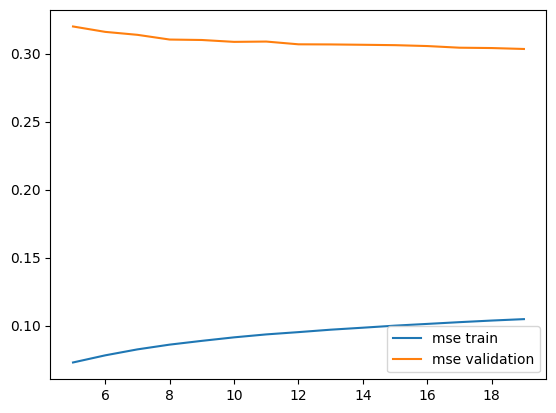

The best amount of neighbors is: 5
Score of the best amount of neighbors: 0.569


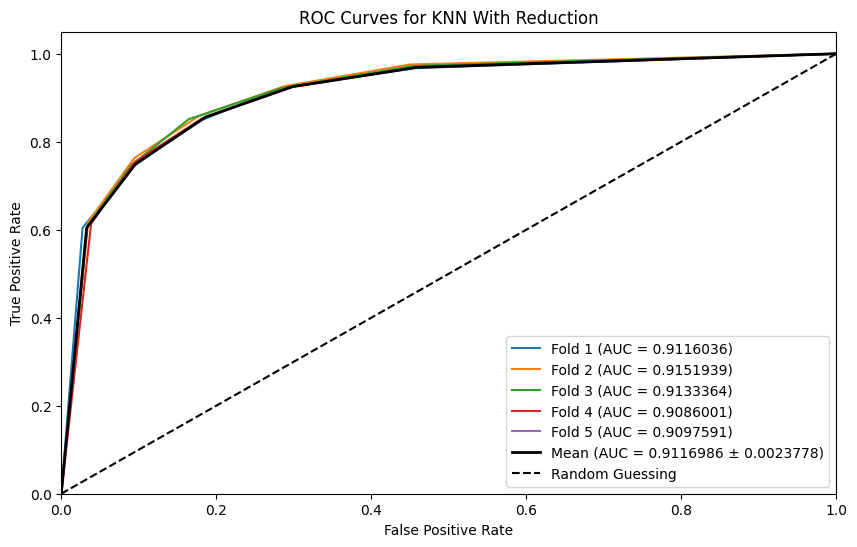

KNN validation AUC score with dimension reduction: 0.583958812249587


In [24]:
Knn_reducted(encoded_train_x_after_pca,y_pca_train,encoded_validation_x_after_pca,y_pca_validation)

<div style="direction:rtl">2. מודל KNN ללא שימוש בPCA על הTRAIN SET</div>

In [25]:
def Unreducted_knn(X_train_unred,y_train_runred,X_Validation_unred,y_Validation_unred):   
    # CALIBRATING KNN MODEL WITHOUT THE PCA DIMENSION REDUCTIONS

    #creating a number of neighbors list for KNN to calibrate to
    num_of_neighbors=range(5,20)
    #creating a list to hold the score of each number of neighbors checked,keep track of the best neighbor and the best score of that neighbor
    neighbors_score=[]
    best_neighbor=None
    mse_train_val=[]
    mse_vaidation_val=[]
    #initializing KNN model to calibrate the optimal number of neighbors
    for curr_neighbor in num_of_neighbors:
        calibration_knn=KNeighborsClassifier(n_neighbors=curr_neighbor)
        calibration_knn.fit(X_train_unred,y_train_runred)
        neighbors_score.append(calibration_knn.score(X_Validation_unred,y_Validation_unred))


        mse_train_val.append(mean_squared_error(calibration_knn.predict_proba(X_train_unred)[:, 1],y_train_runred))
        mse_vaidation_val.append(mean_squared_error(calibration_knn.predict_proba(X_Validation_unred)[:, 1],y_Validation_unred))
        
    #plotting the train mse and the validation mse
    mse_train_line=plt.plot(num_of_neighbors,mse_train_val,label="mse train")
    mse_val_line=plt.plot(num_of_neighbors,mse_vaidation_val,label="mse validation")
    plt.legend()
    plt.show()

    best_neighbor=num_of_neighbors[np.argmax(neighbors_score)]
    print("The best amount of neighbors is:",best_neighbor)

    print("Score of the best amount of neighbors:",neighbors_score[np.argmax(neighbors_score)])


    #KNN WITHOUT REDUCTION
    #initializing knn model 
    final_knn=KNeighborsClassifier(n_neighbors=best_neighbor)
    
    # Create the k-fold cross-validation object
    kf = KFold(n_splits=5)

    # Initialize the figure for plotting ROC curves
    plt.figure(figsize=(10, 6))
    plt.title('ROC Curves for KNN Without Reduction')

    encoded_train_kf=pd.DataFrame(X_train_unred)


    # Create an array to store the AUC scores of each fold
    auc_scores = []

    # Perform k-fold cross-validation
    for i, (train_index, val_index) in enumerate(kf.split(encoded_train_kf)):
        # Get the training and validation data for this fold
        X_train, X_val = encoded_train_kf.iloc[train_index], encoded_train_kf.iloc[val_index]
        y_train, y_val = y_train_runred.iloc[train_index], y_train_runred.iloc[val_index]

        # Fit the KNN model on the training data
        final_knn.fit(X_train, y_train)

        # Predict probabilities on the validation data
        y_scores = final_knn.predict_proba(X_val)[:, 1]

        # Compute the false positive rate, true positive rate, and threshold
        fpr, tpr, thresholds = roc_curve(y_val, y_scores)

        # Compute the area under the ROC curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Add the AUC score to the array
        auc_scores.append(roc_auc)

        # Plot the ROC curve for this fold
        plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.7f})')

    # Calculate the mean and standard deviation of the AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Plot the mean ROC curve
    plt.plot(fpr, tpr, label=f'Mean (AUC = {mean_auc:.7f} ± {std_auc:.7f})', linewidth=2, color='black')

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    # Set the x-axis and y-axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the labels for x-axis and y-axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add a legend to the plot
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()
    val_auc = roc_auc_score(y_Validation_unred,final_knn.predict_proba(X_Validation_unred)[:, 1])
    print("KNN Validation AUC Without dimension reduction:",val_auc)


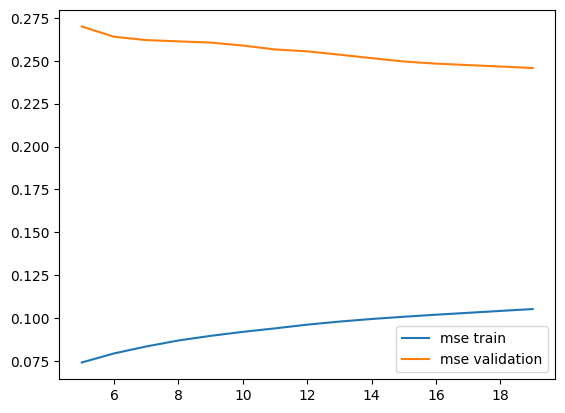

The best amount of neighbors is: 19
Score of the best amount of neighbors: 0.6342666666666666


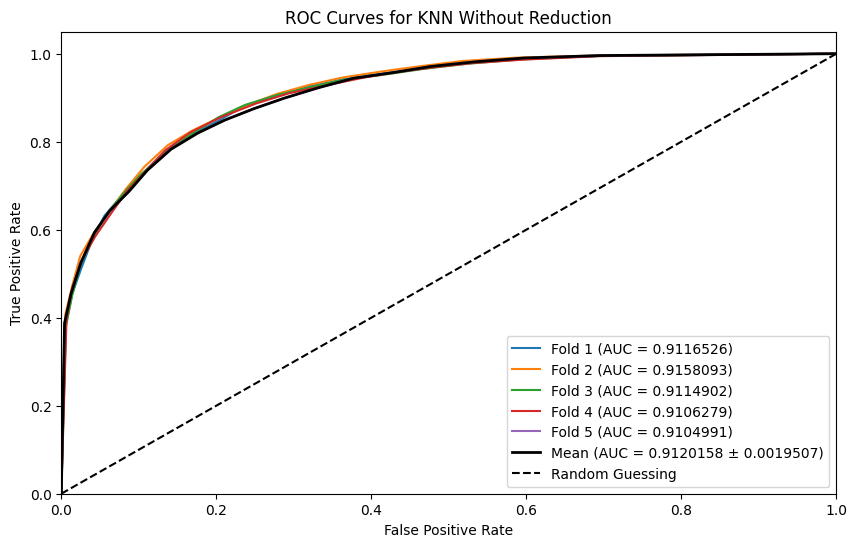

KNN Validation AUC Without dimension reduction: 0.687586119147629


In [26]:
Unreducted_knn(encoded_train,y_train,encoded_x_validation,y_Validation)

<div style="direction:rtl">
על מנת לבדוק האם השימוש בPCA תרם לביצועי מודל KNN ביצענו שני ניתוחים: מודל KNN עם שימוש בPCA, KNN ללא שימוש בPCA.
עבור כל מודל ביצענו כיול של ההיפר-פרמטר (מספר השכנים האופטימלי) ורק לאחר מכן אימנו את המודל וביצענו ולידציה.
בניתוח הראשון של המודל (עם PCA) מצאנו כי הנתונים הינם: מספר שכנים אופטימלי - 6 והAUC=0.58.
לעומת זאת, בניתוח השני של המודל (ללא PCA) מצאנו כי משתפרים מעט (אך עדיין במצב של OVERFITTING), מספר השכנים האופטימלי הינו 19 והAUC=0.68.

פירוט נוסף על המסקנה הנ"ל מופיע בדו"ח המפורט בתחילת החלק השלישי.
</div>

<div style="direction:rtl">3. מודל רגרסיה לוגיסטית
</div>

In [27]:
def logistic_regression(X_train_unred,y_train_runred,X_Validation_unred,y_Validation_unred):
    #Logistic regression calibration of best C
    powers = range(-50, 20)
    Cs = [10**p for p in powers]
    C_score = []
    best_C = None
    best_score = 0.0
    mse_train_val = []
    mse_validation_val = []
    #initializing the logistic regression to find the best C
    for curr_c in Cs:
        calibration_logistic = LogisticRegression(penalty="l1", solver="liblinear", C=curr_c)
        calibration_logistic.fit(X_train_unred, y_train_runred)

        score = calibration_logistic.score(X_Validation_unred, y_Validation_unred)
        C_score.append(score)

        mse_train = mean_squared_error(calibration_logistic.predict_proba(X_train_unred)[:, 1], y_train_runred)
        mse_validation = mean_squared_error(calibration_logistic.predict_proba(X_Validation_unred)[:, 1], y_Validation_unred)
        mse_train_val.append(mse_train)
        mse_validation_val.append(mse_validation)

        if score > best_score:
            best_score = score
            best_C = curr_c

    # Plotting the bias-variance tradeoff
    plt.plot(Cs, mse_train_val, label="Train MSE")
    plt.plot(Cs, mse_validation_val, label="Validation MSE")
    plt.axvline(x=best_C, color='r', linestyle='--', label='Best C')

    plt.xlabel('C')
    plt.ylabel('MSE')
    plt.xscale('log')
    plt.title('Bias-Variance Tradeoff')
    plt.legend()

    # Set the x-axis limits to zoom in on the optimal C area
    plt.xlim([1e-10, 1e+10])

    plt.show()

    print("The optimum C is:", best_C)
    best_Lambda = 1 / best_C
    print("The optimum Lambda is:", best_Lambda)

    print("The score of the validation set with optimum lambda:", C_score[np.argmax(C_score)])

    plt.plot(powers,C_score)

   
    #initialize logistic regression with the best C
    log_reg=LogisticRegression(penalty="l1",C=best_C,solver="liblinear")

    # Create the k-fold cross-validation object
    kf = KFold(n_splits=5)

    # Initialize the figure for plotting ROC curves
    plt.figure(figsize=(10, 6))
    plt.title('ROC Curves for Logistic Regression')

    encoded_train_kf=pd.DataFrame(X_train_unred)

    # Create an array to store the AUC scores of each fold
    auc_scores = []

    # Perform k-fold cross-validation
    for i, (train_index, val_index) in enumerate(kf.split(encoded_train_kf)):
        # Get the training and validation data for this fold
        X_train, X_val = encoded_train_kf.iloc[train_index], encoded_train_kf.iloc[val_index]
        y_train, y_val = y_train_runred.iloc[train_index], y_train_runred.iloc[val_index]

        # Fit the logistic regression on the training data
        log_reg.fit(X_train, y_train)

        # Predict probabilities on the validation data
        y_scores = log_reg.predict_proba(X_val)[:, 1]

        # Compute the false positive rate, true positive rate, and threshold
        fpr, tpr, thresholds = roc_curve(y_val, y_scores)

        # Compute the area under the ROC curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Add the AUC score to the array
        auc_scores.append(roc_auc)

        # Plot the ROC curve for this fold
        plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.7f})')

    # Calculate the mean and standard deviation of the AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Plot the mean ROC curve
    plt.plot(fpr, tpr, label=f'Mean (AUC = {mean_auc:.7f} ± {std_auc:.7f})', linewidth=2, color='black')

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    # Set the x-axis and y-axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the labels for x-axis and y-axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add a legend to the plot
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()
    val_auc = roc_auc_score(y_Validation_unred,log_reg.predict_proba(X_Validation_unred)[:,1])
    print("Logistic regression validation AUC score:",val_auc)
    

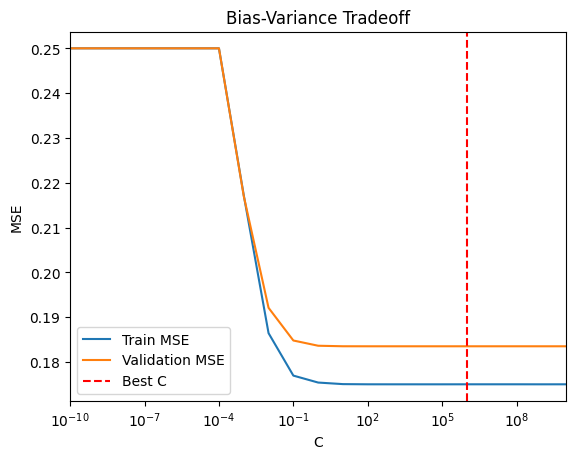

The optimum C is: 1000000
The optimum Lambda is: 1e-06
The score of the validation set with optimum lambda: 0.7286


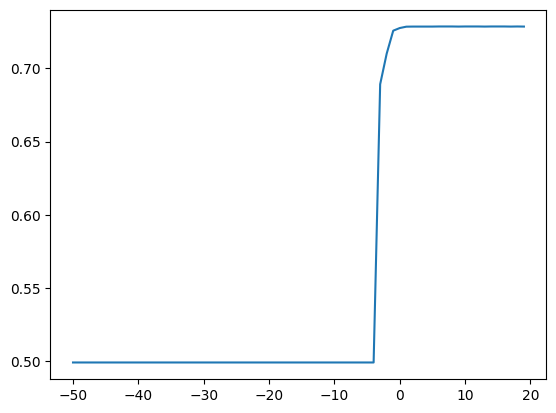

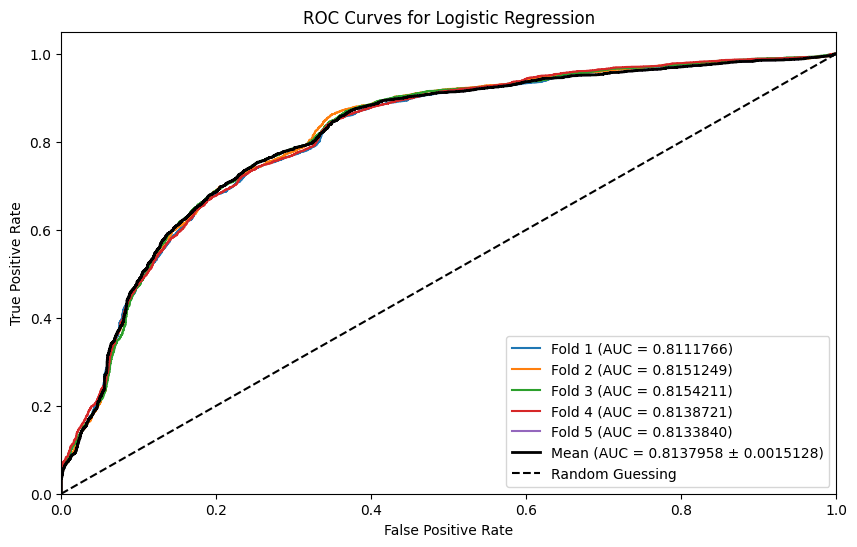

Logistic regression validation AUC score: 0.7996556291875793


In [28]:
logistic_regression(encoded_train,y_train,encoded_x_validation,y_Validation)

**<div style="direction:rtl">מודלים מתקדמים - RANDOM FOREST CLASSIFIER וMLP</div>**

<div style="direction:rtl">1. מודל MLP</div>

In [29]:
def MLP_model(X_train_unred,y_train_runred,X_Validation_unred,y_Validation_unred):
    #MLP calibration 
    powers = range(-2, 5)
    alphas = [10**p for p in powers]
    score_of_all_alphas = []
    mse_train_val = []
    mse_validation_val = []
    #finding the optimal alpha after initializing MLP model
    for curr_alpha in alphas:
        my_mlp_clsfr = MLPClassifier(hidden_layer_sizes=(10, 10,10), activation="relu", max_iter=250, solver='sgd',
                                    verbose=False, tol=1e-4, random_state=42, learning_rate_init=.001, alpha=curr_alpha)
        my_mlp_clsfr.fit(X_train_unred, y_train_runred)
        score_of_all_alphas.append(my_mlp_clsfr.score(X_Validation_unred, y_Validation_unred))

        mse_train = mean_squared_error(my_mlp_clsfr.predict_proba(X_train_unred)[:, 1], y_train_runred)
        mse_validation = mean_squared_error(my_mlp_clsfr.predict_proba(X_Validation_unred)[:, 1], y_Validation_unred)
        mse_train_val.append(mse_train)
        mse_validation_val.append(mse_validation)

    # Plotting the bias-variance tradeoff
    plt.plot(alphas, mse_train_val, label="Train MSE")
    plt.plot(alphas, mse_validation_val, label="Validation MSE")

    best_alpha = alphas[np.argmax(score_of_all_alphas)]
    plt.axvline(x=best_alpha, color='r', linestyle='--', label='Best Alpha')

    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.xscale('log')
    plt.title('Bias-Variance Tradeoff')
    plt.legend()

    # Set the x-axis limits to zoom in on the area of optimal Alpha
    plt.xlim([10**-2, 10**4])

    plt.show()

    #plotting the scores of all alphas, X axis is the powers array (powers is the scale of alphas) and Y axis is the validation accuracy scores 
    plt.plot(powers,score_of_all_alphas)

    #the best alpha is the alpha with the maximum score, so the best alpha will be where in the index of that has the maximum score in the scores list
    alpha_opt_mlp = alphas[np.argmax(score_of_all_alphas)]

    print("The optimal alpha is: ", alpha_opt_mlp)
    
    print("The score of the validation set with optimum alpha:",score_of_all_alphas[np.argmax(score_of_all_alphas)])

    #MLP AFTER CALIBRATION 
    # Building the MLP with the optimal alpha and then fitting it on the training data
    my_best_MLP = MLPClassifier(hidden_layer_sizes=(10, 10,10),activation='relu', max_iter=250, solver='sgd', verbose=False, tol=1e-4, random_state=42, learning_rate_init=.001, alpha=alpha_opt_mlp)
   
    # Create the k-fold cross-validation object
    kf = KFold(n_splits=5)

    # Initialize the figure for plotting ROC curves
    plt.figure(figsize=(10, 6))
    plt.title('ROC Curves for MLP Classifier')

    encoded_train_kf=pd.DataFrame(X_train_unred)


    # Create an array to store the AUC scores of each fold
    auc_scores = []

    # Perform k-fold cross-validation
    for i, (train_index, val_index) in enumerate(kf.split(encoded_train_kf)):
        # Get the training and validation data for this fold
        X_train, X_val = encoded_train_kf.iloc[train_index], encoded_train_kf.iloc[val_index]
        y_train, y_val = y_train_runred.iloc[train_index], y_train_runred.iloc[val_index]

        # Fit the MLP model on the training data
        my_best_MLP.fit(X_train, y_train)

        # Predict probabilities on the validation data
        y_scores = my_best_MLP.predict_proba(X_val)[:, 1]

        # Compute the false positive rate, true positive rate, and threshold
        fpr, tpr, thresholds = roc_curve(y_val, y_scores)

        # Compute the area under the ROC curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Add the AUC score to the array
        auc_scores.append(roc_auc)

        # Plot the ROC curve for this fold
        plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.7f})')

    # Calculate the mean and standard deviation of the AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Plot the mean ROC curve
    plt.plot(fpr, tpr, label=f'Mean (AUC = {mean_auc:.7f} ± {std_auc:.7f})', linewidth=2, color='black')

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    # Set the x-axis and y-axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the labels for x-axis and y-axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add a legend to the plot
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()
    val_auc = roc_auc_score(y_Validation_unred, my_best_MLP.predict_proba(X_Validation_unred)[:, 1])
    print("MLP AUC validation score:",val_auc)

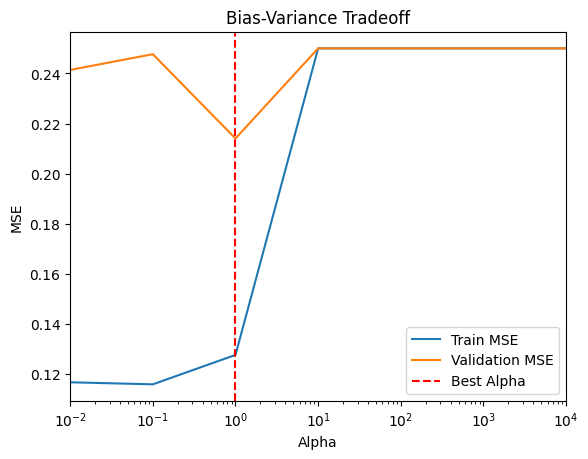

The optimal alpha is:  1
The score of the validation set with optimum alpha: 0.6604


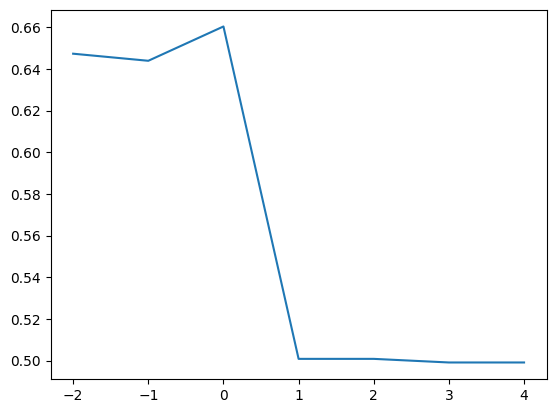

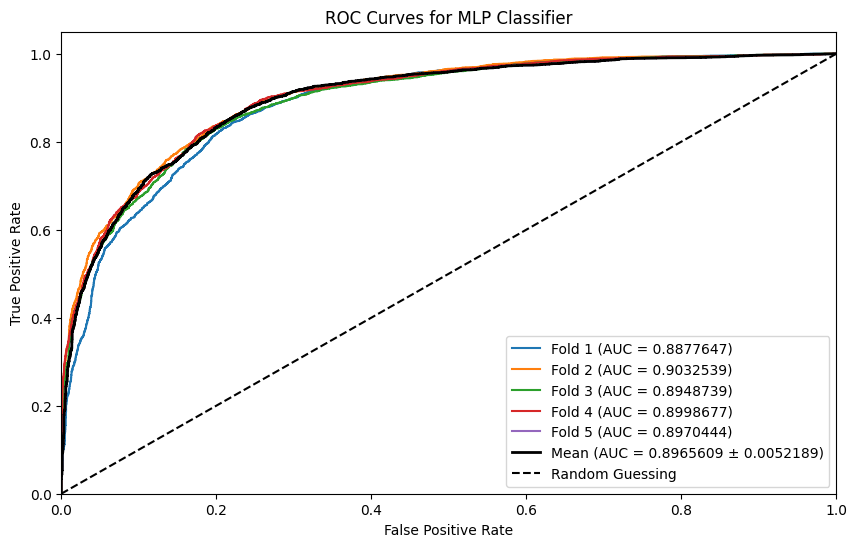

MLP AUC validation score: 0.7684573310095812


In [30]:
MLP_model(encoded_train,y_train,encoded_x_validation,y_Validation)

**<div style="direction:rtl">2. מודל Random Forest (חלק שלישי רביעי וחמישי)</div>**

<div style="direction:rtl">לאחר ניתוח כלל המודלים הסקנו כי מודל זה הוא המיטבי להתמודדות עם הדאטה והבעיה הקיימת בפרוייקט. לכן בשלב זה והלאה נעבוד עם מודל Random Forest ועליו נבצע כיול היפר-פרמטרים, אימון, ולידציה, K-FOLD CROSS VALIDATION ולבסוף ניבוי בעזרת מודל זה את הTEST SET.

בקוד מטה ניתן לראות גם את בחירת ההיפר-פרמטרים האופטימליים (חלק שלישי בפרוייקט) ובנוסף ניתן לראות את החלק הרביעי הכולל ביצוע - Confusion Matrix, K-Fold Cross Validation. לבסוף גם הרצת המודל וניבוע התוצאות על הTEST SET (החלק החמישי - ביצוע פרדיקציה).
בהמשך יבוצע שיפור למודל בעזרת כלי שלא נלמד בקורס, ולאחר השיפור נבצע את הפרדיקציה על הTEST SET.
</div>

In [31]:
def Random_forest_model(X_train_unred,y_train_runred,X_Validation_unred,y_Validation_unred,testfile):
    #RANDOM FOREST MODEL - CALIBRATiON OF THE HYPERPARAMETERS 
    #creating dictionary for searching out of them the best hyper parameter in each setting
    param_dict={"n_estimators": [200], 'max_leaf_nodes': [350,500,700],"max_features":[14], "criterion": ["entropy","gini"]}
    
    #initializing the randomforestclassifier model and then using it on GridSearchCV to find best hyper parameters with roc_auc score, and k-fold = 5
    forest_model=RandomForestClassifier(random_state=0)
    forest_clsf=GridSearchCV(estimator=forest_model,n_jobs=-1,param_grid=param_dict,refit=True,scoring="roc_auc",cv=5)

    # Create the k-fold cross-validation object
    kf = KFold(n_splits=5)

    # Initialize the figure for plotting ROC curves
    plt.figure(figsize=(10, 6))
    plt.title('ROC Curves for Random Forest Classifier')

    encoded_train_kf=pd.DataFrame(X_train_unred)
   
    # Create an array to store the AUC scores of each fold
    auc_scores = []

    # Perform k-fold cross-validation
    for i, (train_index, val_index) in enumerate(kf.split(encoded_train_kf)):
        # Get the training and validation data for this fold
        X_train, X_val = encoded_train_kf.iloc[train_index], encoded_train_kf.iloc[val_index]
        y_train, y_val = y_train_runred.iloc[train_index], y_train_runred.iloc[val_index]

        # Fit the random forest classifier on the training data
        forest_clsf.fit(X_train, y_train)

        # Predict probabilities on the validation data
        y_scores = forest_clsf.predict_proba(X_val)[:, 1]

        # Compute the false positive rate, true positive rate, and threshold
        fpr, tpr, thresholds = roc_curve(y_val, y_scores)

        # Compute the area under the ROC curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Add the AUC score to the array
        auc_scores.append(roc_auc)

        # Plot the ROC curve for this fold
        plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.7f})')

    # Calculate the mean and standard deviation of the AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Plot the mean ROC curve
    plt.plot(fpr, tpr, label=f'Mean (AUC = {mean_auc:.7f} ± {std_auc:.7f})', linewidth=2, color='black')

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    # Set the x-axis and y-axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the labels for x-axis and y-axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add a legend to the plot
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()
    
    #using the Preproccessing_test function to fill the test set and preproccess it
    test_set,test_set_names=Preproccessing_test(testfile)
    test_set_names=pd.DataFrame(test_set_names)
    test_set=pd.DataFrame(test_set)  
    encoded_train_kf=pd.DataFrame(X_train_unred,columns=['vsize', 'imports', 'exports', 'has_debug', 'has_relocations', 'has_resources',
                                                          'has_signature', 'has_tls', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 
                                                          'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B',
                                                            'file_type_trid_0', 'file_type_trid_1', 'file_type_trid_2', 'file_type_trid_3',
                                                            'file_type_trid_4', 'file_type_trid_5', 'file_type_trid_6', 'C_0', 'C_1', 'C_2'])
    importances = forest_clsf.best_estimator_.feature_importances_

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = encoded_train_kf.columns[indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance")

    # Add bars
    plt.bar(range(encoded_train_kf.shape[1]), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(encoded_train_kf.shape[1]), names, rotation=90)

    # Show plot
    plt.show()

    #calculating the predicions and writing the predictions to the copy df
    test_set["predicted"]=forest_clsf.predict_proba(test_set)[:,1]
    test_set_names["predict_proba"]=test_set["predicted"].copy()
    test_set['classification'] = test_set['predicted'].apply(lambda x: "MALICIOUS FILE" if x > 0.5 else "NOT MALICIOUS FILE")
    print(test_set['classification'].value_counts())

    #Confusion matrix on validation set
    train_conf_mat_mlp=confusion_matrix(y_Validation_unred,forest_clsf.predict(X_Validation_unred))
    class_labels = ['Not Malicious', 'Malicious']
    disp = ConfusionMatrixDisplay(confusion_matrix=train_conf_mat_mlp, display_labels=class_labels)
    disp.plot(values_format="d")
    plt.show()


    print("Optimal hyper-parameters of the Random Forest model:",forest_clsf.best_params_)
    val_auc = roc_auc_score(y_Validation_unred,forest_clsf.predict_proba(X_Validation_unred)[:,1])
    print ("Random forest validation AUC score:",val_auc)

    return test_set,test_set_names


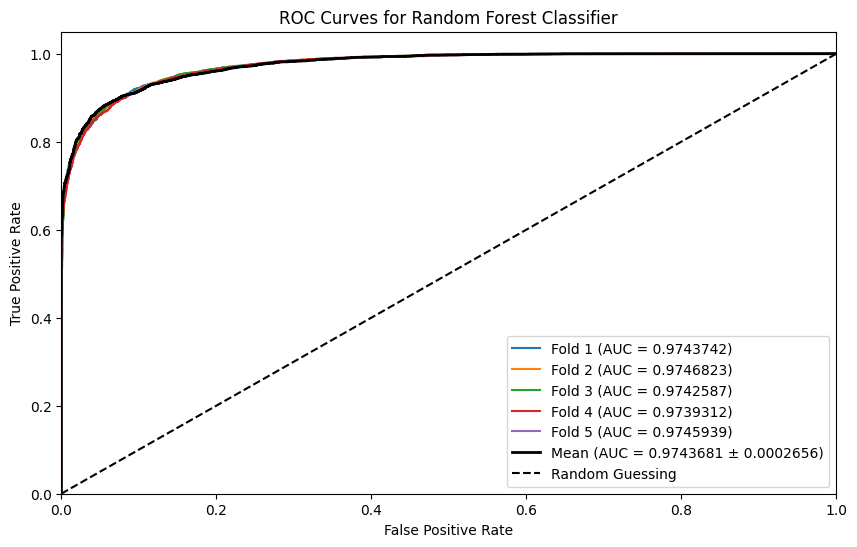

(18000, 29)


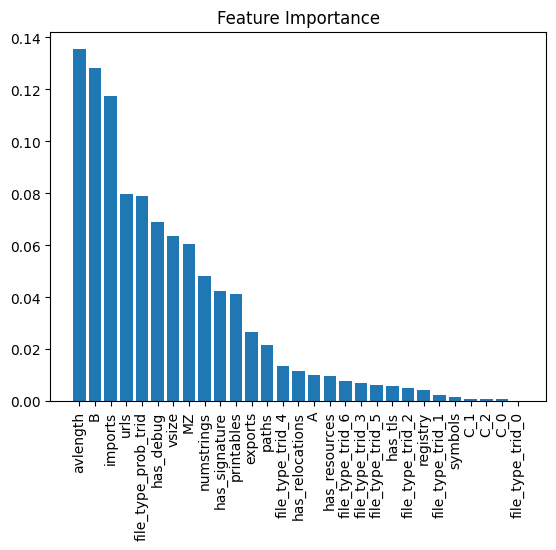

MALICIOUS FILE        9128
NOT MALICIOUS FILE    8872
Name: classification, dtype: int64


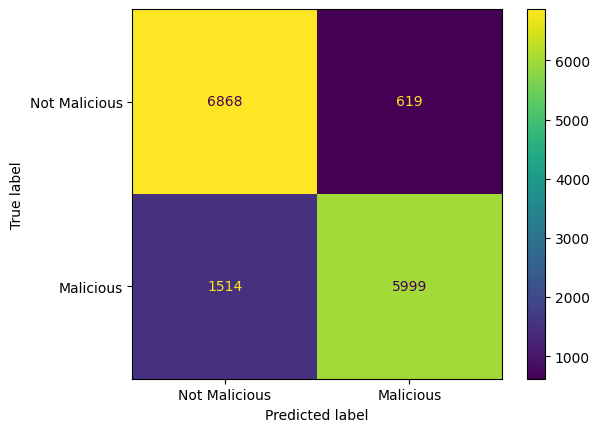

Optimal hyper-parameters of the Random Forest model: {'criterion': 'entropy', 'max_features': 14, 'max_leaf_nodes': 700, 'n_estimators': 200}
Random forest validation AUC score: 0.9512902536542732


In [32]:
test_plot_kde,test_export=Random_forest_model(encoded_train,y_train,encoded_x_validation,y_Validation,"test.csv")

In [33]:
def Random_forest_model1(X_train_unred, y_train_runred, X_Validation_unred, y_Validation_unred, testfile):

    # Initializing the random forest classifier model with the optimal parameters found in the first forest above and improving predictions with CalibratedClassifierCV
    forest_model = RandomForestClassifier(random_state=0,n_estimators=200,max_leaf_nodes=700, max_features=14, criterion="entropy")
    forest_model.fit(X_train_unred, y_train_runred)
    forest_clsf = CalibratedClassifierCV(forest_model,method="sigmoid", cv=5, n_jobs=-1)

    # Create the k-fold cross-validation object
    kf = KFold(n_splits=5)

    # Initialize the figure for plotting ROC curves
    plt.figure(figsize=(10, 6))
    plt.title('ROC Curves for Random Forest Classifier')

    encoded_train_kf = pd.DataFrame(X_train_unred)

    # Create an array to store the AUC scores of each fold
    auc_scores = []

    # Perform k-fold cross-validation
    for i, (train_index, val_index) in enumerate(kf.split(encoded_train_kf)):
        # Get the training and validation data for this fold
        X_train, X_val = encoded_train_kf.iloc[train_index], encoded_train_kf.iloc[val_index]
        y_train, y_val = y_train_runred.iloc[train_index], y_train_runred.iloc[val_index]

        # Fit the random forest classifier on the training data
        forest_clsf.fit(X_train, y_train)

        # Predict probabilities on the validation data
        y_scores = forest_clsf.predict_proba(X_val)[:, 1]

        # Compute the false positive rate, true positive rate, and threshold
        fpr, tpr, thresholds = roc_curve(y_val, y_scores)

        # Compute the area under the ROC curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Add the AUC score to the array
        auc_scores.append(roc_auc)

        # Plot the ROC curve for this fold
        plt.plot(fpr, tpr, label=f'Fold {i + 1} (AUC = {roc_auc:.7f})')

    # Calculate the mean and standard deviation of the AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Plot the mean ROC curve
    plt.plot(fpr, tpr, label=f'Mean (AUC = {mean_auc:.7f} ± {std_auc:.7f})', linewidth=2, color='black')

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    # Set the x-axis and y-axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the labels for the x-axis and y-axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add a legend to the plot
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()

    #using the Preproccessing_test function to fill the test set and preproccess it
    test_set, test_set_names = Preproccessing_test(testfile)
    test_set_names = pd.DataFrame(test_set_names)
    test_set = pd.DataFrame(test_set)

    # Creating a confusion matrix for the random forest model - predicting the whole encoded train with reduction (encoded train is reduced)
    train_conf_mat_mlp = confusion_matrix(y_Validation_unred, forest_clsf.predict(X_Validation_unred))
    class_labels = ['Not Malicious', 'Malicious']
    disp = ConfusionMatrixDisplay(confusion_matrix=train_conf_mat_mlp, display_labels=class_labels)
    disp.plot(values_format="d")
    plt.show()

    # print("Optimal hyperparameters of the Random Forest model:", forest_model.get_params())
    val_auc = roc_auc_score(y_Validation_unred, forest_clsf.predict_proba(X_Validation_unred)[:, 1])
    print("Random forest validation AUC score:", val_auc)

    #finding the best threshold for classification of test by the validation set results
    thresholds = np.arange(0.1, 1.1, 0.1)
    best_threshold = None
    best_metric = 0.0

    for threshold in thresholds:
        # Predict labels based on the threshold
        binary_predictions = np.where(forest_clsf.predict_proba(X_val)[:, 1] >= threshold, 1, 0)

        # Evaluate the classifiers performance
        metric = accuracy_score(y_val, binary_predictions)
       # Replace with desired metric

        # Update the best threshold and metric if necessary
        if metric > best_metric:
            best_metric = metric
            best_threshold = threshold


    mask = forest_clsf.predict_proba(X_Validation_unred)[:, 1] >= best_threshold
    masked_data = np.where(mask, 1, 0)

    # Plotting the distribution of masked data
    sns.histplot(data=masked_data, bins=2, discrete=True)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Masked Labels in Validation Dataset')
    plt.xticks([0, 1])
    plt.show()

    print("Best threshold:", best_threshold)
    test_set["predicted"]=forest_clsf.predict_proba(test_set)[:,1]
    test_set_names["predict_proba"]=test_set["predicted"].copy()
    test_set['classification'] = test_set['predicted'].apply(lambda x: "MALICIOUS FILE" if x >best_threshold else "NOT MALICIOUS FILE")
    print(test_set['classification'].value_counts())

    return test_set,test_set_names

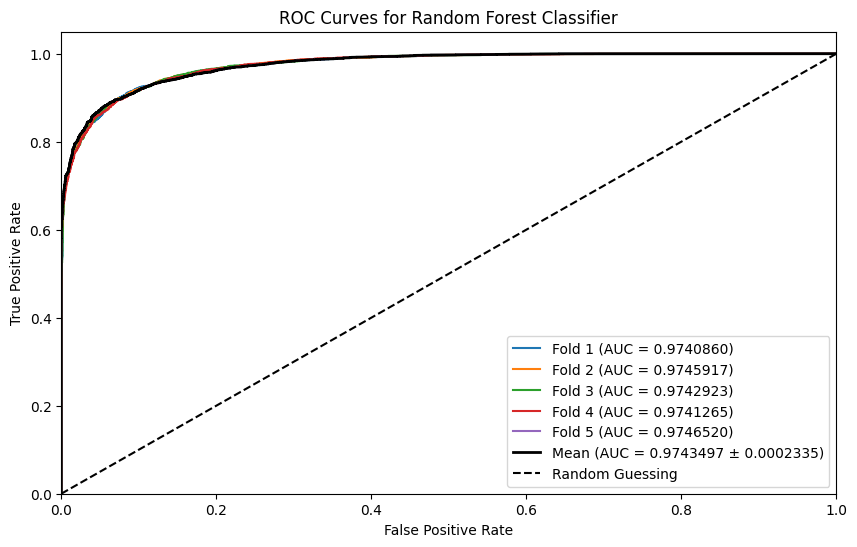

(18000, 29)


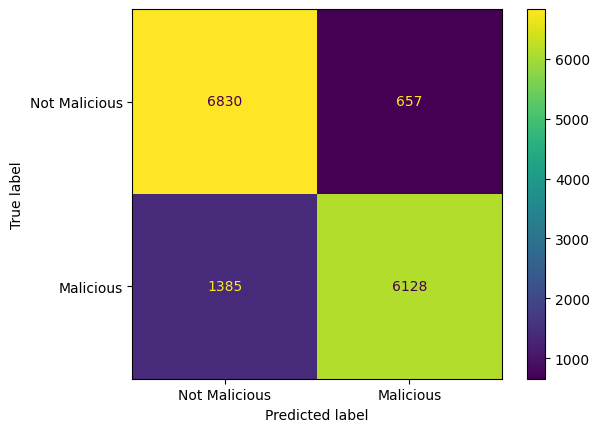

Random forest validation AUC score: 0.9522162475474815


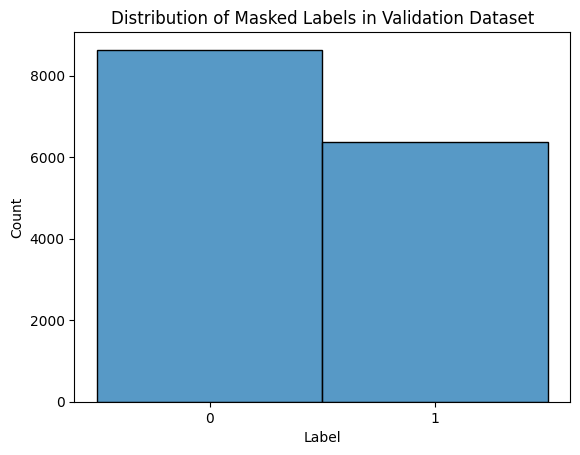

Best threshold: 0.6
NOT MALICIOUS FILE    10175
MALICIOUS FILE         7825
Name: classification, dtype: int64


In [34]:
test_plot_kde,test_export=Random_forest_model1(encoded_train,y_train,encoded_x_validation,y_Validation,"test.csv")

<div style="direction:rtl"> גרף KDE - הצגת התפלגות נתוני הTEST SET לפי סיווגן    
</div>

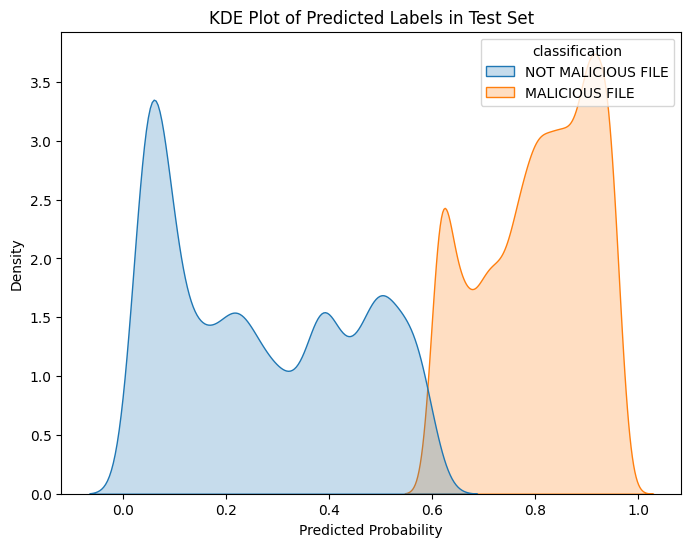

In [35]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=test_plot_kde, x='predicted', hue='classification', fill=True, common_norm=False)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('KDE Plot of Predicted Labels in Test Set')
plt.show()

**<div style="direction:rtl"> ייצוא תוצאות הניבוי לקובץ אקסל</div>**

In [36]:
test_export.to_csv("results_19.csv",index=False)

**<div style="direction:rtl"> חלק שישי - שימוש בכלים שלא נלמדו בקורס </div>**

<div style="direction:rtl"> הכלי אשר לא נלמד ומומש בפרויקט הנ"ל הינו CalibratedClassifierCV.
הסבר מופרט על בחירת הכלי, משמעותו והשפעתו על ביצועי המודל מפורטות בחלק שישי בדו"ח הפרוייקט.
</div>

**<div style="direction:rtl"> PIPELINE</div>**

In [37]:
def pipeline(train_file, test_file) -> None:
    #import dataset 
    dataset=Import_train_for_modeling(train_file)
    #removing the unwanted features from the dataset and splitting the labels from the features
    final_numeric_features,final_categorial_features,x,y,x_pca=Remove_features_split_train_labels(dataset)
    x_train, x_validation, y_train, y_Validation = train_test_split(x, y, test_size=0.25,random_state = 42)
    x_pca_train=x_train.copy()
    y_pca_train=y_train.copy()
    #creating a copy for pca of X_validation
    x_pca_validation=x_validation.copy()
    y_pca_validation=y_Validation.copy()

    #dealing with outliers
    train_x=quantile_outliers_to_limit_and_plot(x_train,2)
    x_pca_train=quantile_outliers_to_limit_and_plot(x_pca_train,2)
    x_validation=quantile_outliers_to_limit_and_plot(x_validation,2)
    x_pca_validation=quantile_outliers_to_limit_and_plot(x_pca_validation,2)

    #filling NAN in datasets
    train_x,y_train=fill_empty_numeric_features(train_x,y_train)
    x_pca_train,y_pca_train=fill_empty_numeric_features(x_pca_train,y_pca_train)
    x_validation,y_Validation=fill_empty_numeric_features(x_validation,y_Validation)
    x_pca_validation,y_pca_validation=fill_empty_numeric_features(x_pca_validation,y_pca_validation)

    train_x,y_train=fill_empty_categoric_features(train_x,train_x.copy(),y_train,final_categorial_features,2)
    x_pca_train,y_pca_train=fill_empty_categoric_features(x_pca_train,x_pca_train.copy(),y_pca_train,final_categorial_features,2)
    x_validation,y_Validation=fill_empty_categoric_features(x_validation,x_validation.copy(),y_Validation,final_categorial_features,2)
    x_pca_validation,y_pca_validation=fill_empty_categoric_features(x_pca_validation,x_pca_validation.copy(),y_pca_validation,final_categorial_features,2)

    #normalization
    encoded_train,encoded_train_before_norm=Encoding_and_Normalization_of_data(train_x)
    encoded_train_x_before_pca,encoded_train_for_pca_before_norm=Encoding_and_Normalization_of_data(x_pca_train)
    encoded_x_validation,encoded_validation_before_norm=Encoding_and_Normalization_of_data(x_validation)
    encoded_x_validation_before_pca,encoded_validation_before_norm_pca=Encoding_and_Normalization_of_data(x_pca_validation)

    #PCA
    store,encoded_train_x_after_pca=encoding_train_pca_reduction(encoded_train_x_before_pca)
    store,encoded_validation_x_after_pca=encoding_train_pca_reduction(encoded_x_validation_before_pca)


    
    test_plot_kde,test_export=Random_forest_model(encoded_train,y_train,encoded_x_validation,y_Validation,test_file)
    test_plot_kde,test_export=Random_forest_model1(encoded_train,y_train,encoded_x_validation,y_Validation,test_file)
    
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=test_plot_kde, x='predicted', hue='classification', fill=True, common_norm=False)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('KDE Plot of Predicted Labels in Test Set')
    plt.show()

    test_export.to_csv("results_19.csv",index=False)


In [38]:
%%capture
pipeline("train.csv", "test.csv")